## Interactively analysing components of rain gage data

Import the files containing all the scripts for analysing rain gage networks. In these files are definitions for three different class object: 

 - **`Rain`**: contains set of gage data or set of radar data at specified locations. 
 - **`RadarGage`**: merges a gage instance of **`Rain`** and a radar instance of **`Rain`** to facilitate comparisons
 - **`Event`**: contains data from specific times to facilitate mapping and other spatial analysis

In [1]:
%matplotlib inline
from rain import *
from common import *
from event import *

#### Charlotte:

Initialize the **`Rain`** object with a file containing all of the data or with a list of years. The output from this are all contained in attributed of the ** `Rain`** class. All of the data are contained in a **`pandas.DataFrame`** object called **`Rain.df`**

In [2]:
path = './input/CHARLOTTE'

rg = Rain(path=path, name='Charlotte_CRN_gage_{YEAR}.csv', year=range(1993, 2016), ngages=71, freq='15min')
rg.ll_file = 'Charlotte_CRN_lat_lon.csv'
rg.get_ll(cols=['lat','lon'])

rg.save_path = './output/Charlotte/'

## Plotting the Rain Rate

Once the data are loaded, make a quick plot to get a sense of the data from this particular location

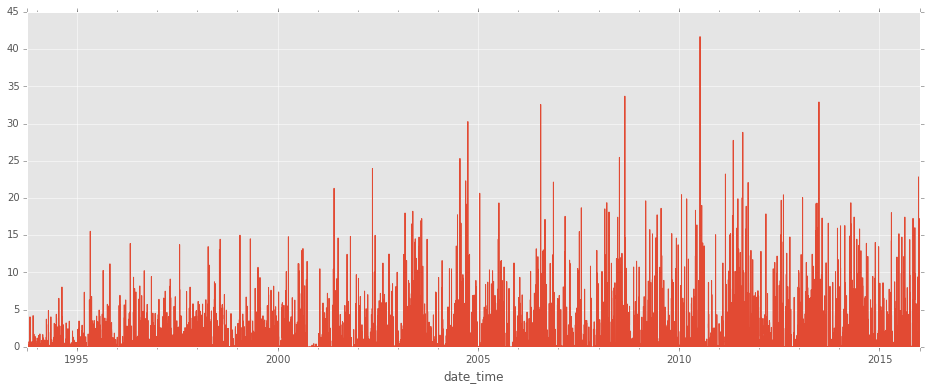

In [11]:
rg.rate.mean(axis=1).plot(figsize=(16,6))
plt.show()

There is an issue with the Charlotte data which I am currently working on resolving. The problem is that for some of the gages that went in later in the time span, zeros were filled back instead of NaNs. This will be reseolved soon hopefully, but until then every straight rain rate needs to be taken with a grain of salt. 

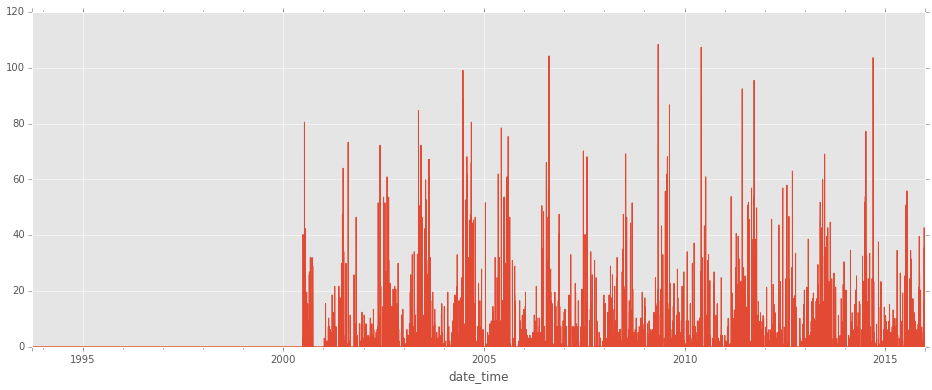

In [20]:
rg.rate['RG60'].plot(figsize=(16,6))
plt.show()

If we are interested in the seasonal and diurnal patterns of rainfall, we can easily plot that up by running:

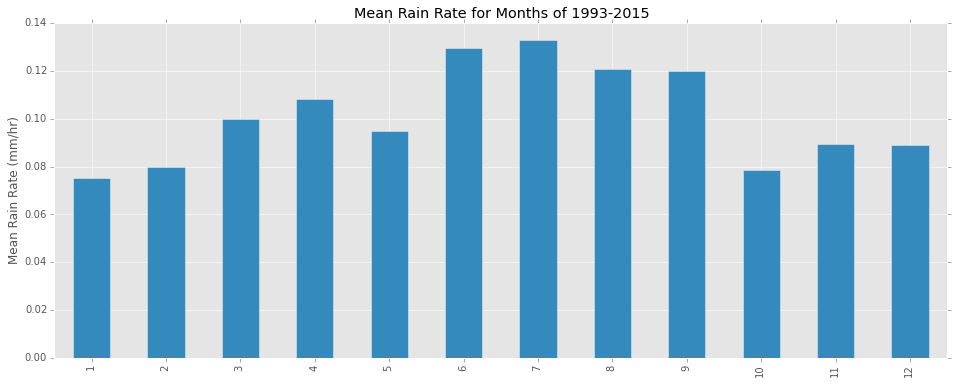

In [14]:
rg.plot_rate(interval='seasonal')

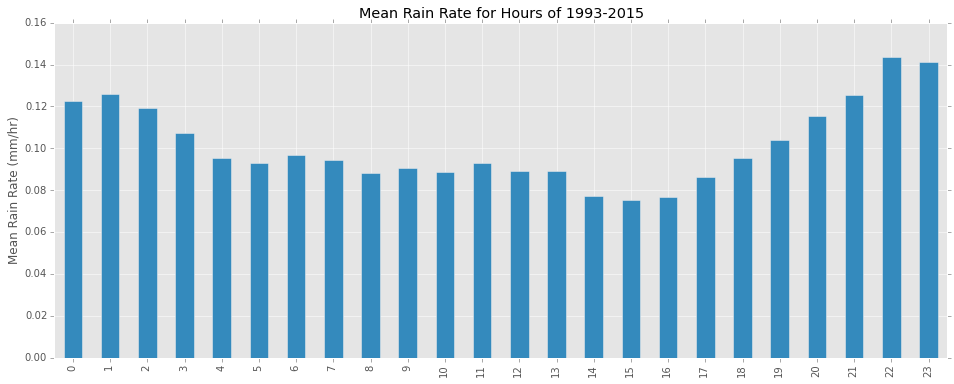

In [15]:
rg.plot_rate(interval='diurnal')

## Plotting probability of wet days occuring

Say we want to determine which days are wet and which aren't based on threshold. The default threshold is the minimum non-zero value recorded over a timestep. The units on this are mm/hr.

In [12]:
rg.thresh

1.0150000000000001

The threshold can be set by using **`Rain.thresh = `** and reset back to the default using **`Rain.reset_thresh()`** 

In [13]:
rg.reset_thresh()

Now we are ready to figure out which of the days are wet and which aren't. We can make a plot of the mean probability that a day will be wet using a variety of thresholds. In this instance we take the mean probability for each month.

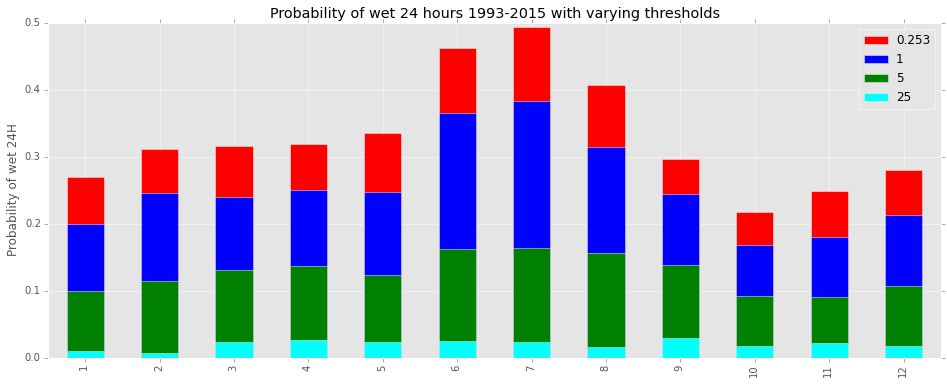

In [16]:
for mm, c in zip([.253, 1, 5, 25], ['red','blue','green','cyan']):
    rg.thresh = mm * rg.per_hour
    rg.plot_prob_wet(interval='seasonal', time_step='24H', base=12, color=c, save=False)
plt.legend([.253, 1, 5, 25])
title = 'Probability of wet 24 hours 1993-2015 with varying thresholds'
plt.title(title)
plt.savefig(rg.save_path + title + '.png')

We can also make plots of the probability that different four hour intervals within the average day will be wet:

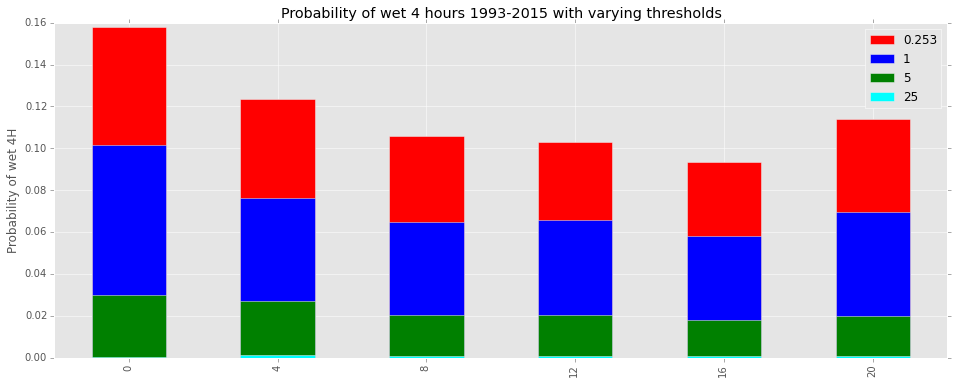

In [17]:
for mm, c in zip([.253, 1, 5, 25], ['red','blue','green','cyan']):
    rg.thresh = mm * rg.per_hour
    rg.plot_prob_wet(interval='diurnal', time_step='4H', color=c, save=False)
plt.legend([.253, 1, 5, 25])
title = 'Probability of wet 4 hours 1993-2015 with varying thresholds'
plt.title(title)
plt.savefig(rg.save_path + title + '.png')

If we are interested in specific gages we can look at just a few: 

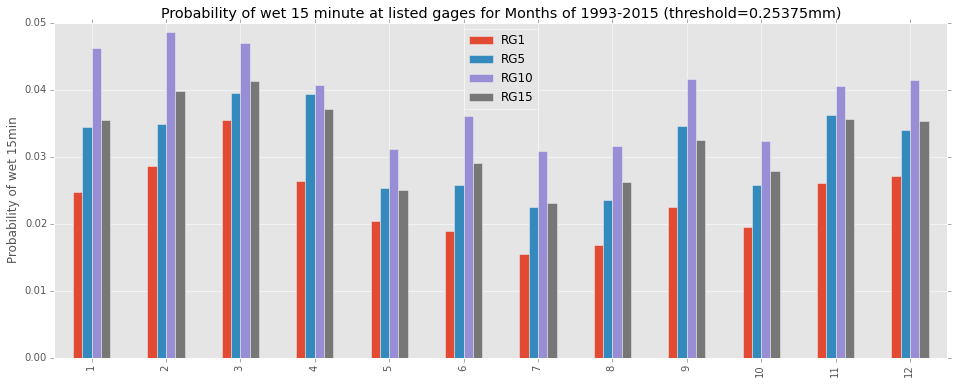

In [33]:
rg.reset_thresh()
rg.plot_prob_wet(interval='seasonal', gage=['RG1', 'RG5', 'RG10', 'RG15'])

## Plotting distribution of rain rates for wet days

When we are satisfied with the wet/dry aspect of things we can make different assortments of boxplots to highlight the distribution of rainfall across months:

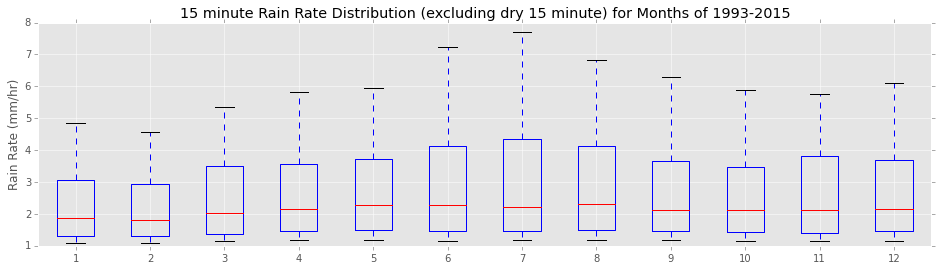

In [19]:
rg.plot_boxplots(interval='seasonal')

Across hours:

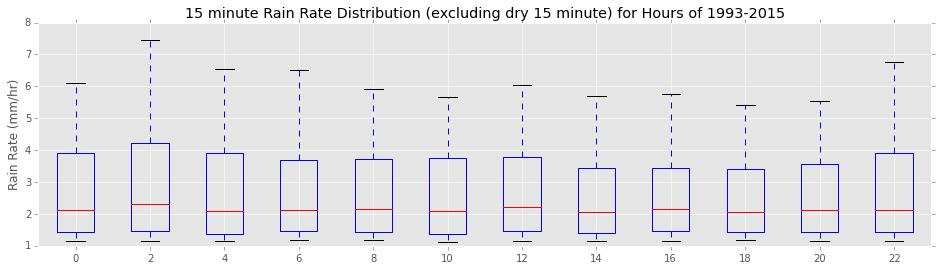

In [20]:
rg.plot_boxplots(interval='diurnal')

That was an average of all the months at each hour, but say we are just interested in September:

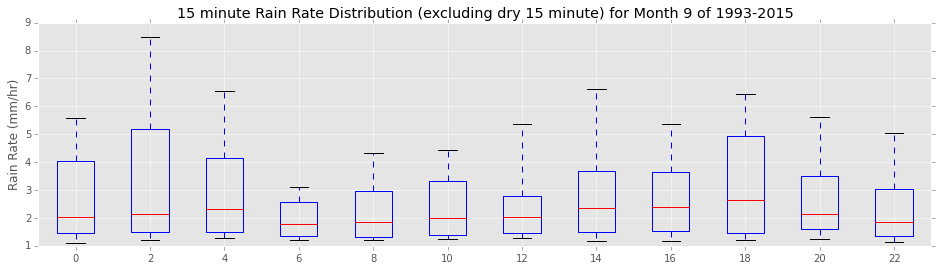

In [21]:
rg.plot_boxplots(interval='diurnal', m=9)

We can also change the time_step at which we evaluate rainfall from 15 minute, to 1 hour, or 1 day, or whatever we want!

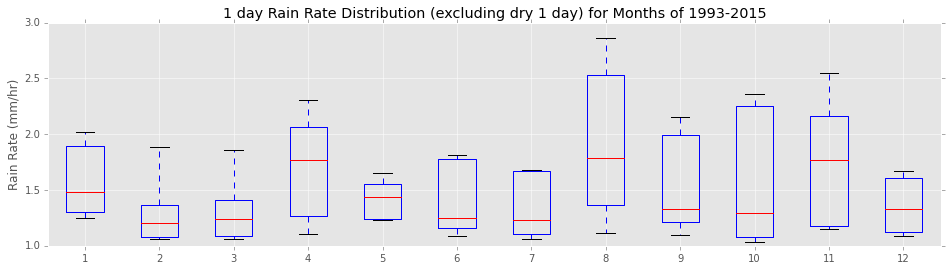

In [22]:
rg.plot_boxplots(interval='seasonal', time_step='1D')

## Mapping Rainfall

Once we are satisfied with the temporal components of the data, we are ready to try mapping the rain in space. As a first pass, we can just plot the mean rain rate at each location. The simplest way to create a may is by setting the keywords `gage=rg.list_gages()`, `bar=False` and `map=True`.

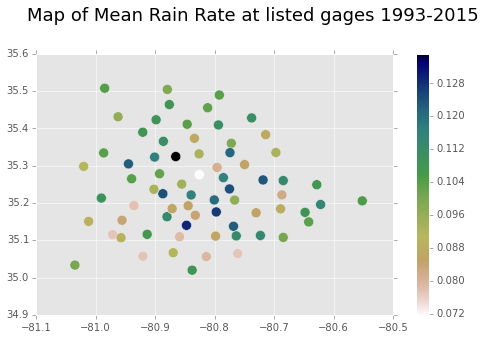

In [10]:
rg.plot_rate(gage=rg.list_gages(), bar=False, map=True)

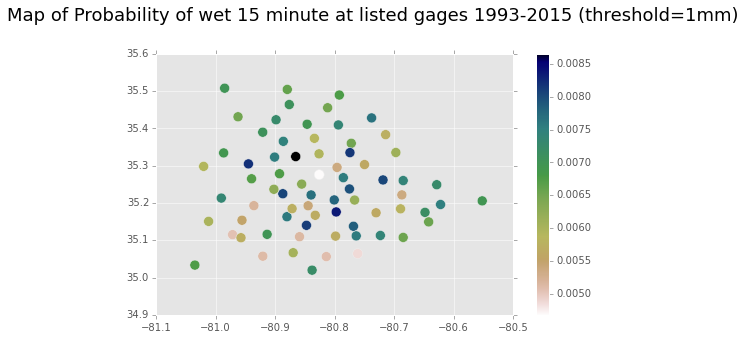

In [11]:
rg.thresh = 1*rg.per_hour
rg.plot_prob_wet(gage=rg.list_gages(), bar=False, map=True)

All of the other keywords that we were using before are still available, so we can set the `time_step` to whatever we want.

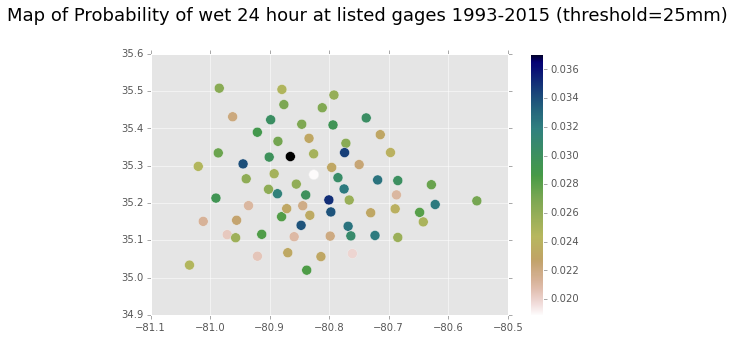

In [8]:
rg.thresh = 25 * rg.per_hour
rg.plot_prob_wet(time_step='24H', base=12, gage=rg.list_gages(), bar=False, map=True)

For more complex uses, we will need to explicitly call the **`Event`** class. One example of this would be using lowess to find the time of peak rainfall within the average day. To accomplish this we will first get a dataframe of the max time using lowess. 

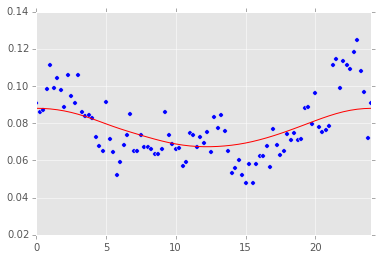

In [14]:
lm = rg.get_max_lowess()

We see in the plot an example of the fit being used. If we want it less smooth, we can change the f value from the default (.25) to any value between 0 and 1 that better suits us. Just be careful when using fractions to make the number a float (1/4**.** **not** 1/4). Once we are satisfied with the fit we can initiate an **`Event`** on a dataframe joining the lat/lon values of the **`Rain`** object with the lowess values. We can set a round color map using `cmap='hsv'`, and set the limits on the color values using `sharec=(min, max)`. To plot against latitude and longitude set `latlon=True`.

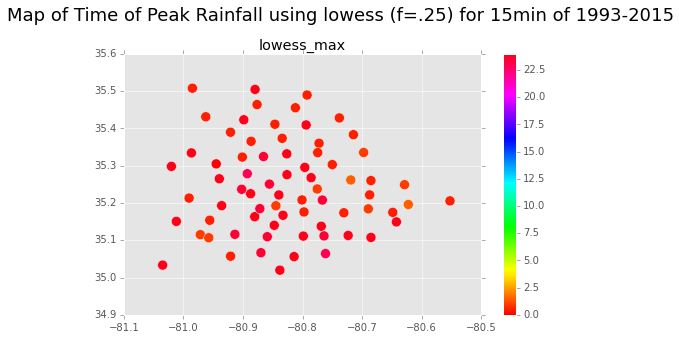

In [15]:
e = Event(rg.ll.join(lm))
title = 'Map of Time of Peak Rainfall using lowess (f=.25) for 15min of {y}'
e.map_rain(latlon=True, cmap='hsv', sharec=(0,24), save_path=rg.save_path, 
           title=title.format(y=rg.year))

## Check out one particular storm

In this case we are looking for the the rainiest 4 days of the entire dataset. In order to find them, can can simply call:

In [19]:
rg.get_rainiest(4, base=0)

To see what we got, we can look at the head of the new dataframe stored at **`Rain.rainiest`**

In [20]:
rg.rainiest.head()

,lat,lon,RG,Y,X,2015-10-04 00:00:00,2011-08-06 00:00:00,1997-07-24 00:00:00,2008-08-28 00:00:00
RG,,,,,,,,,
RG1,35.302925,-80.749975,RG1,3903.585629,-7336.066789,3.439583,3.661833,0.000000,5.731087
RG2,35.331667,-80.826389,RG2,3906.763710,-7340.399641,2.857500,4.751917,0.000000,5.161492
RG3,35.275833,-80.826111,RG3,3900.589991,-7345.441484,2.391833,6.720417,0.000000,4.193857
RG4,35.192778,-80.935833,RG4,3891.406210,-7362.947874,2.878667,2.518833,0.000000,3.720571
RG5,35.278333,-80.892778,RG5,3900.866426,-7351.273203,3.005667,5.513917,5.893012,4.032356


Now if we just care about the rainiest day and want to see when the rain happened we can grab the storm around that day, and check it out.

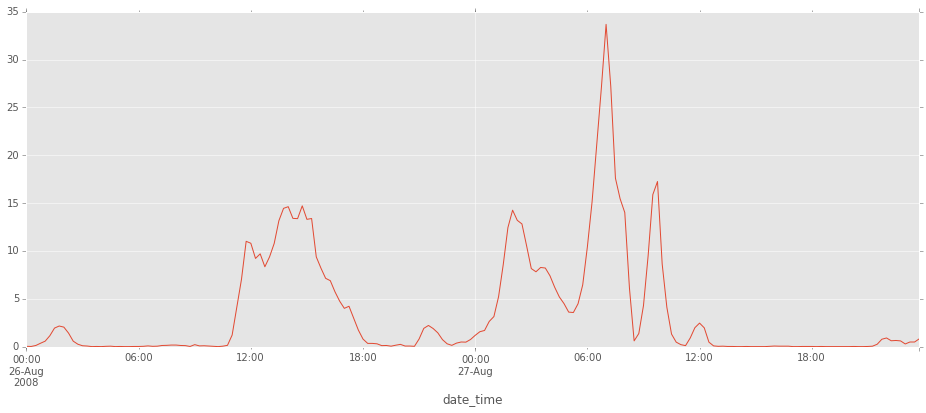

In [13]:
rg.rate['2008-08-26':'2008-08-27'].mean(axis=1).plot(figsize=(16,6))

That is actually two storms, so let's look at the second rainiest day

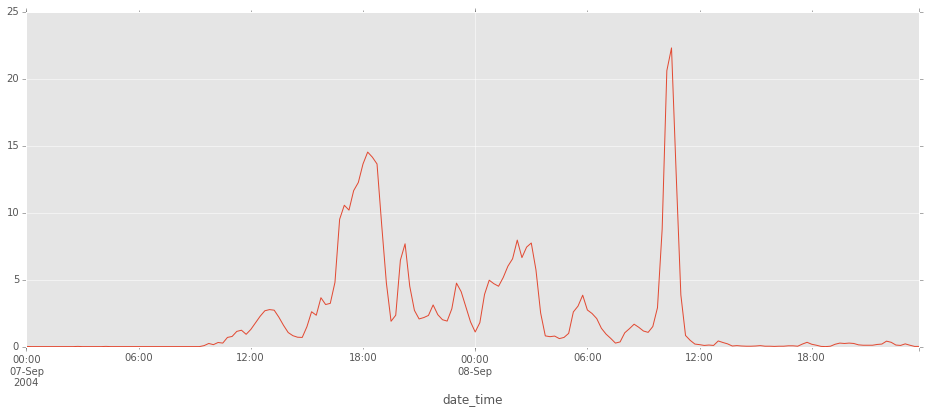

In [16]:
rg.rate['2004-09-07':'2004-09-08'].mean(axis=1).plot(figsize=(16,6))

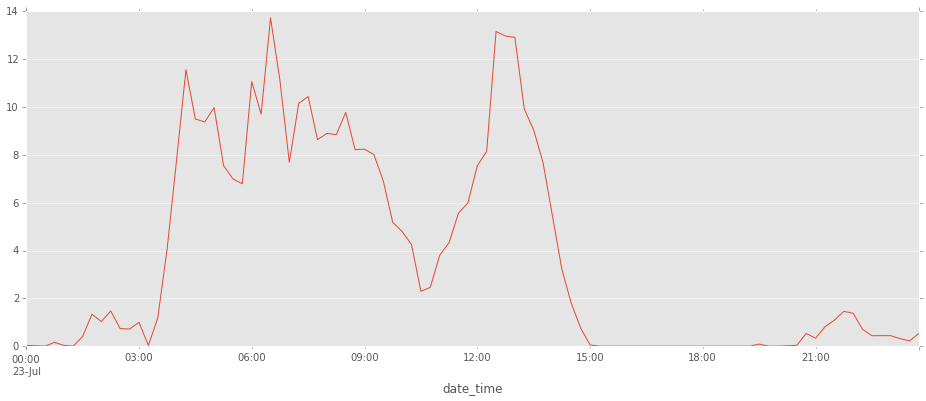

In [21]:
rg.rate['1997-07-23'].mean(axis=1).plot(figsize=(16,6))

In [3]:
rg.get_storm('1997-07-23')
storm = Event(rg.storm)

Be careful computing semi-variograms on this storm, lots of non-positive readings


/home/hub/miniconda2/envs/rain-gage/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



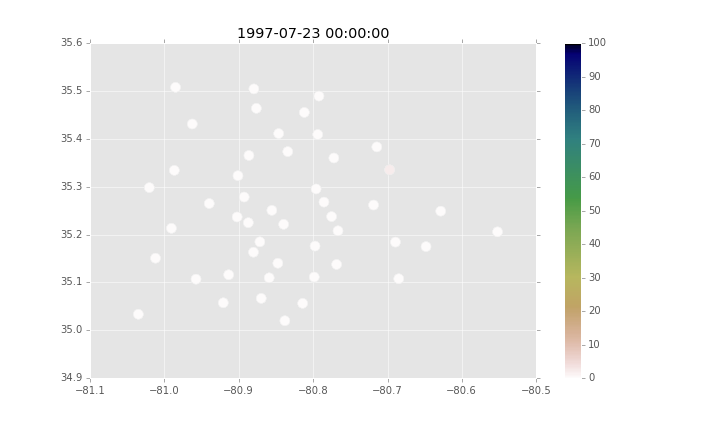
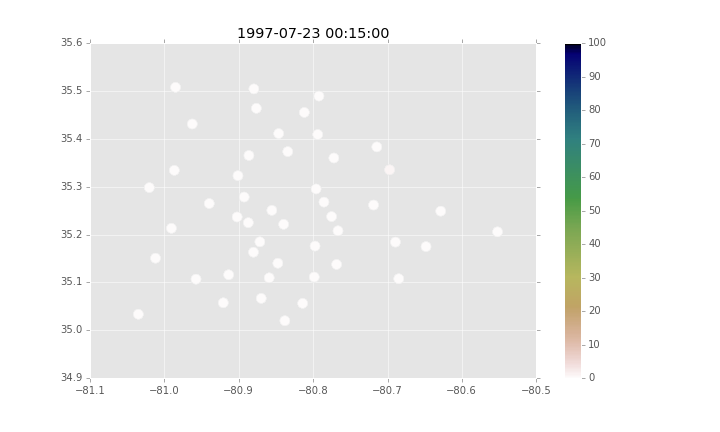
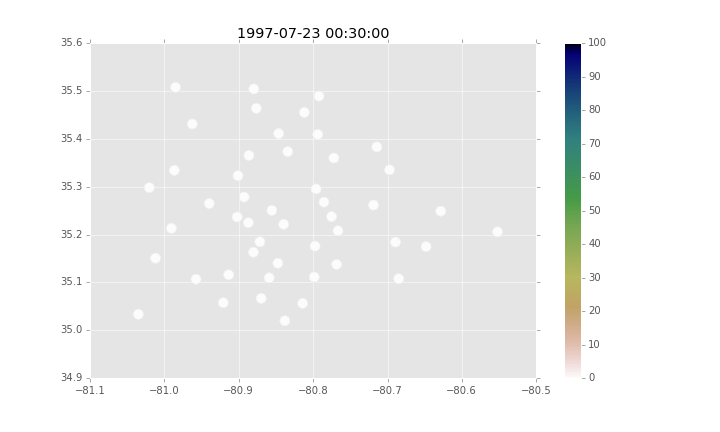
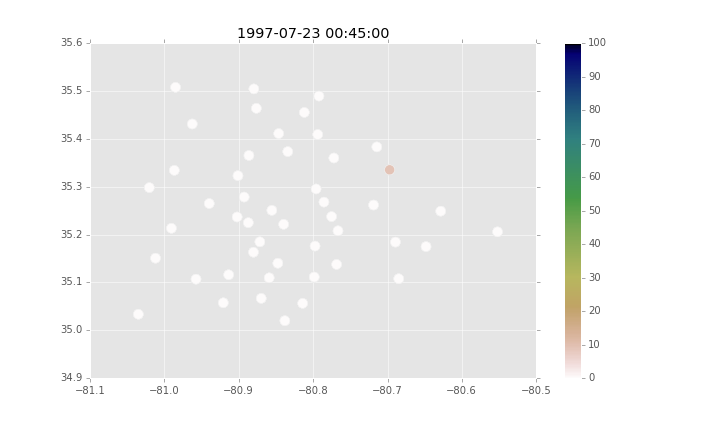
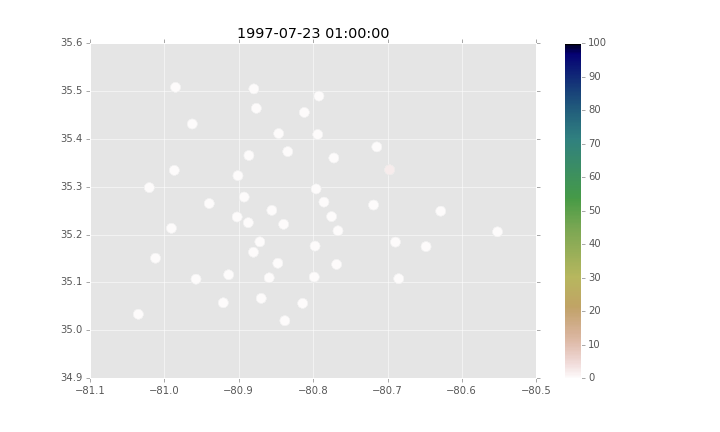
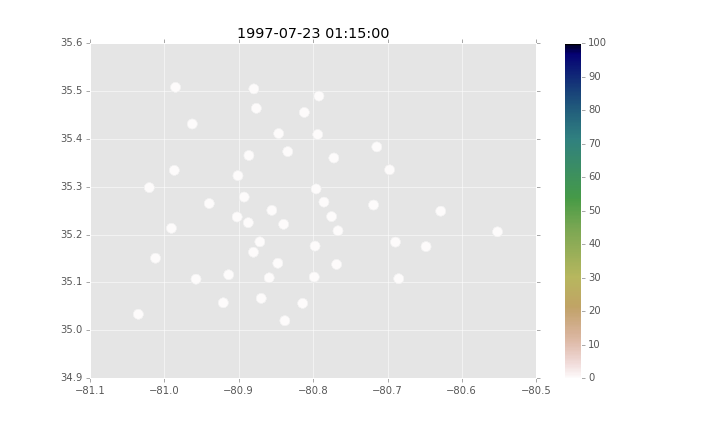
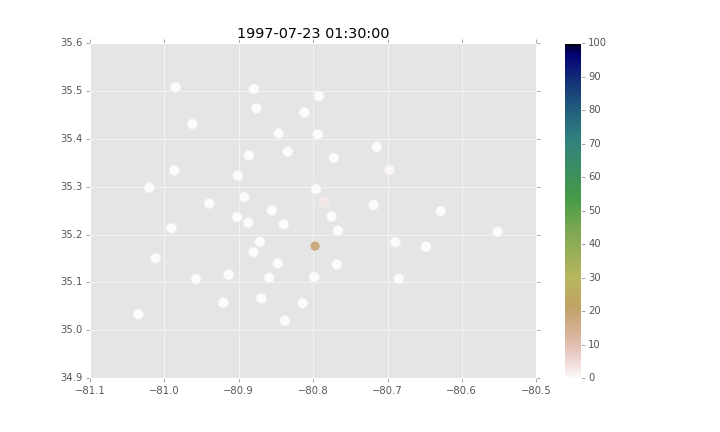
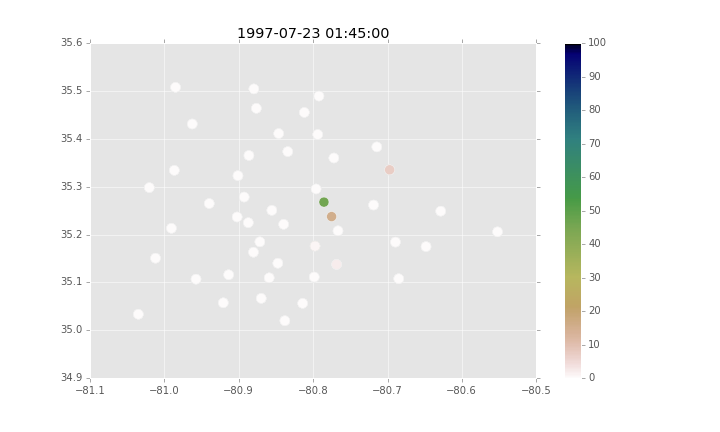
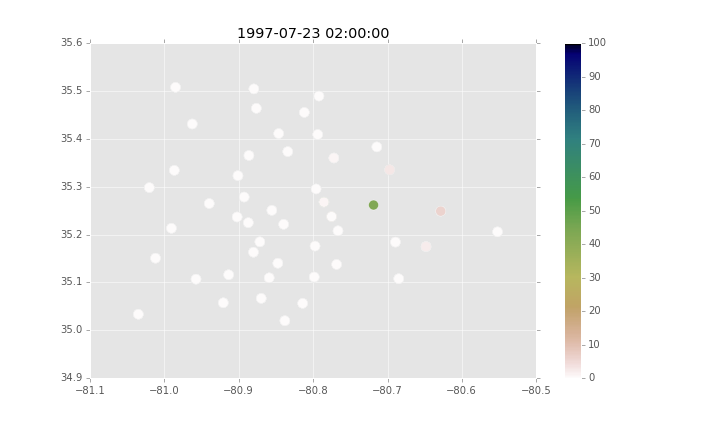
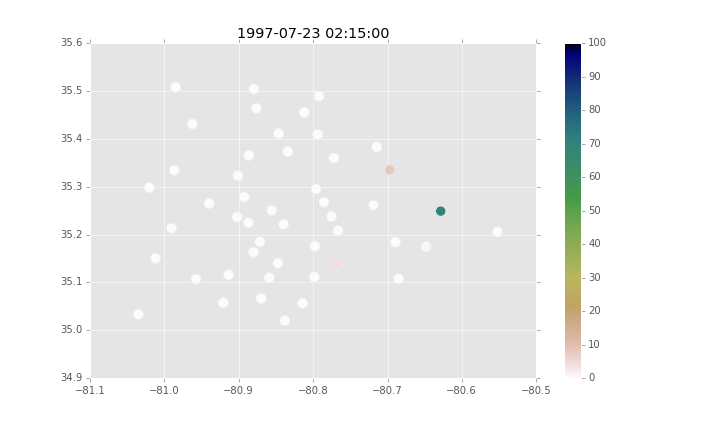
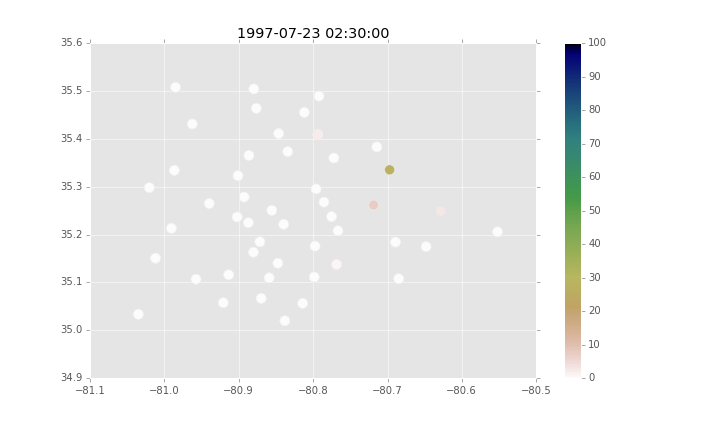
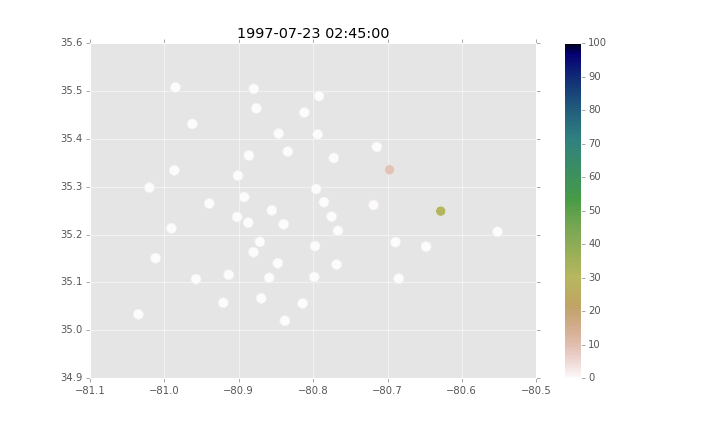
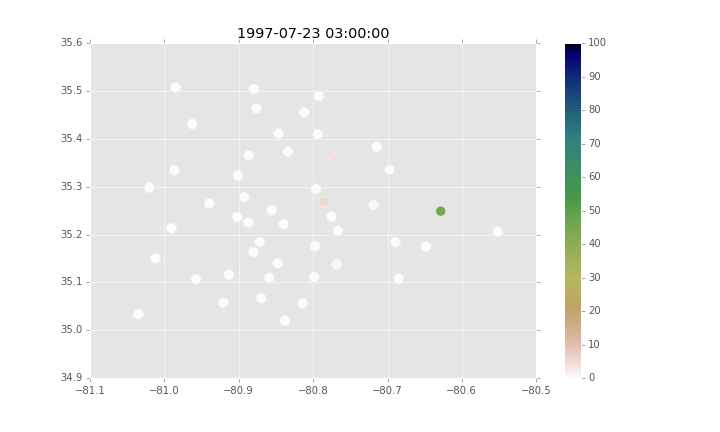
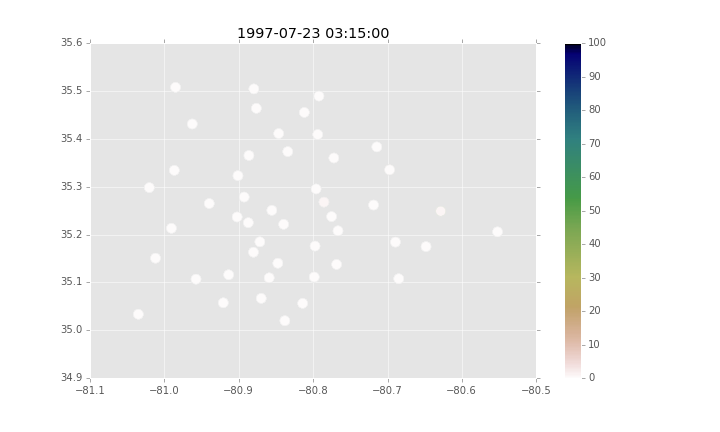
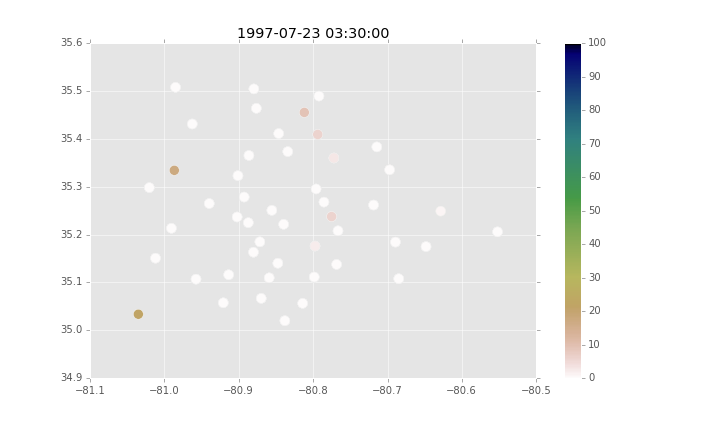
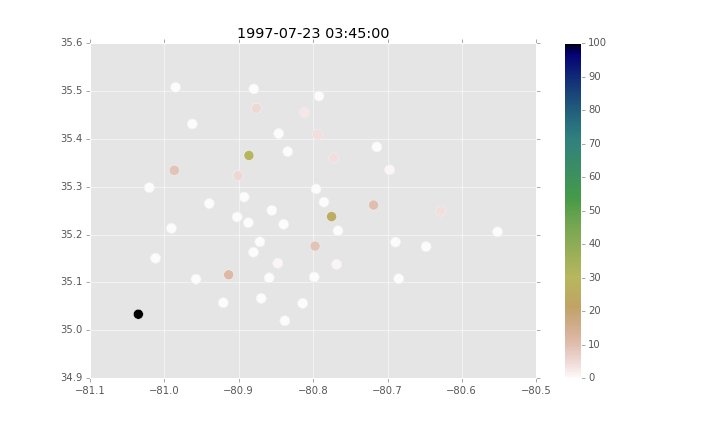
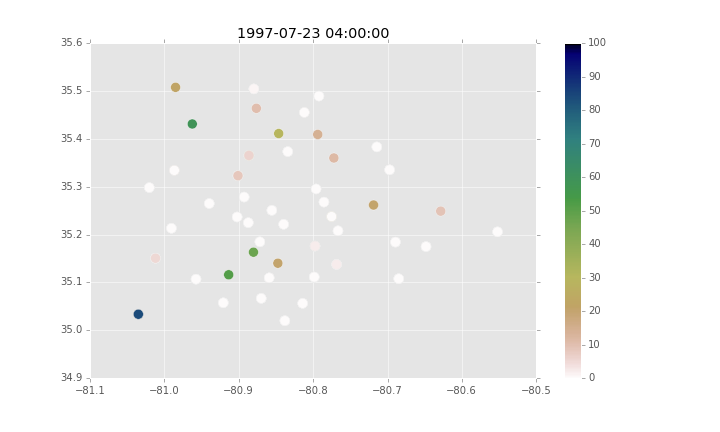
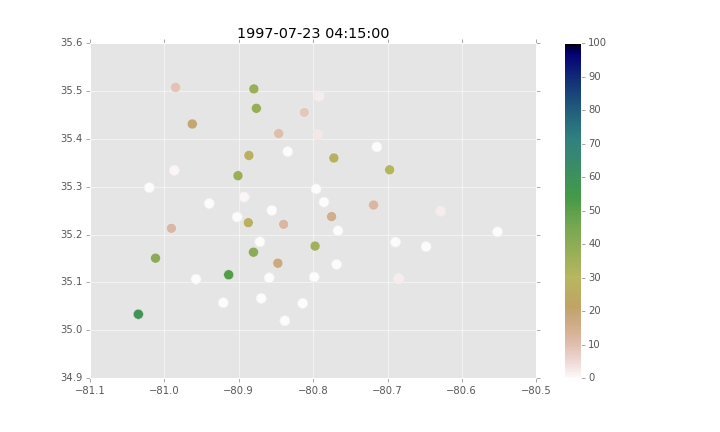
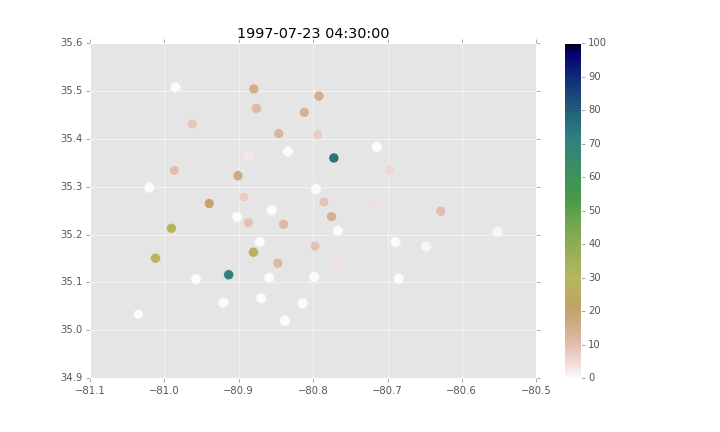
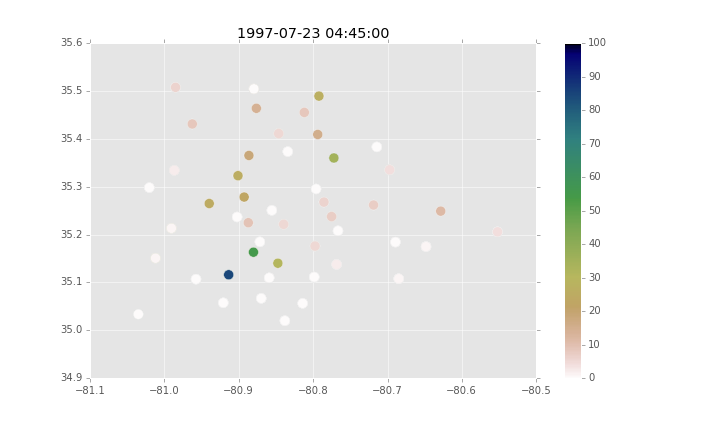
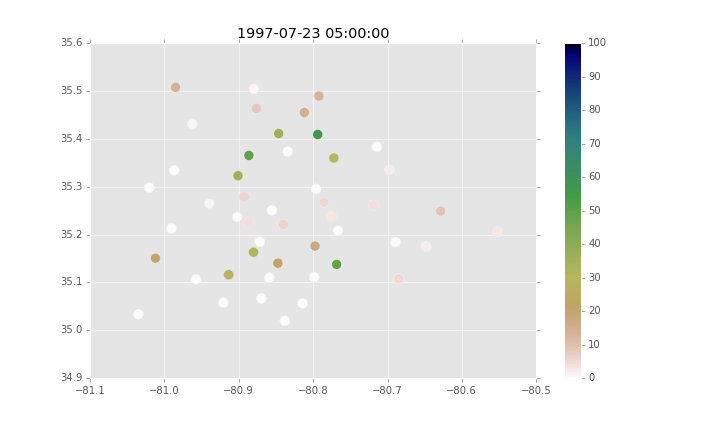
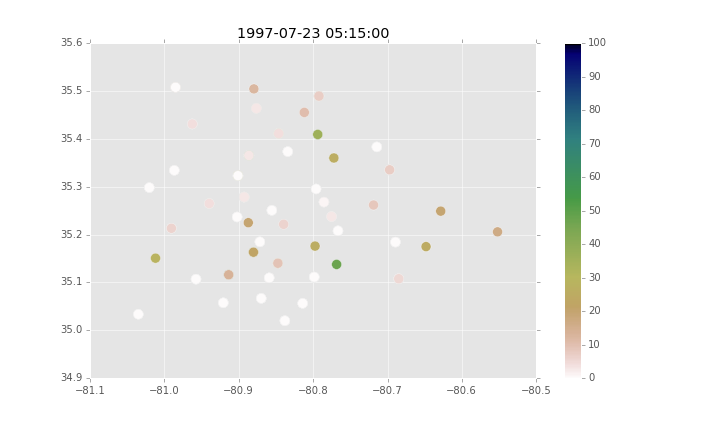
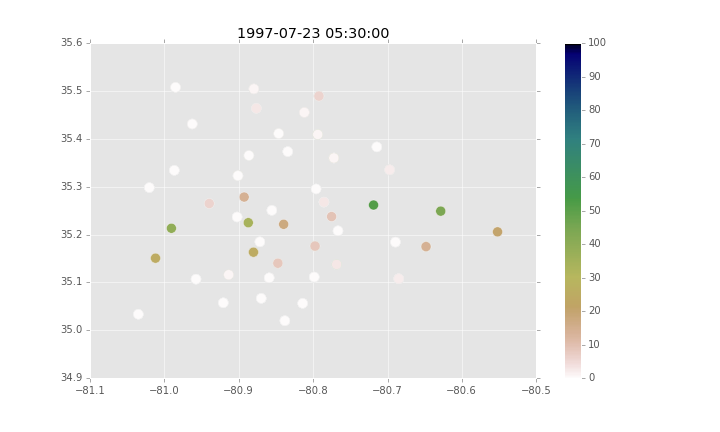
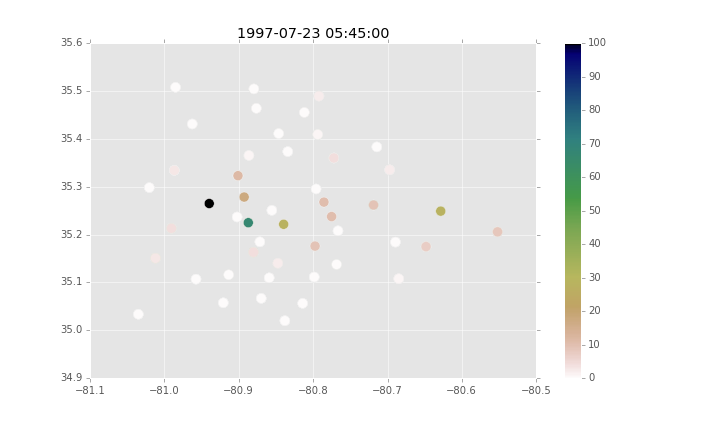
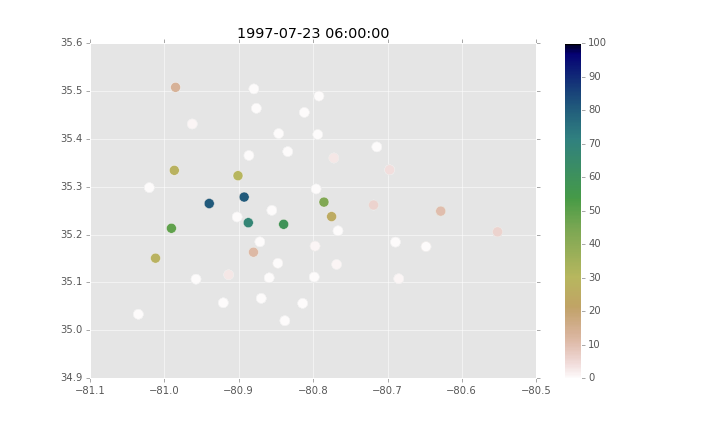
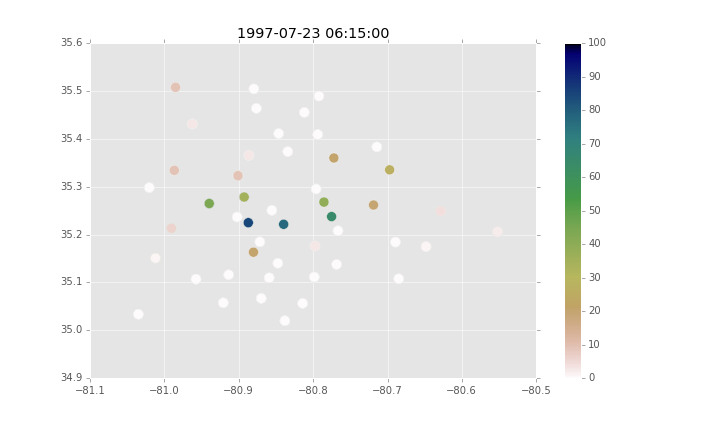
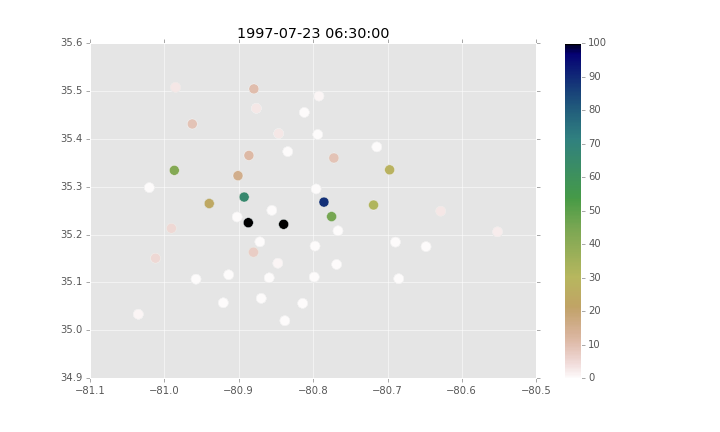
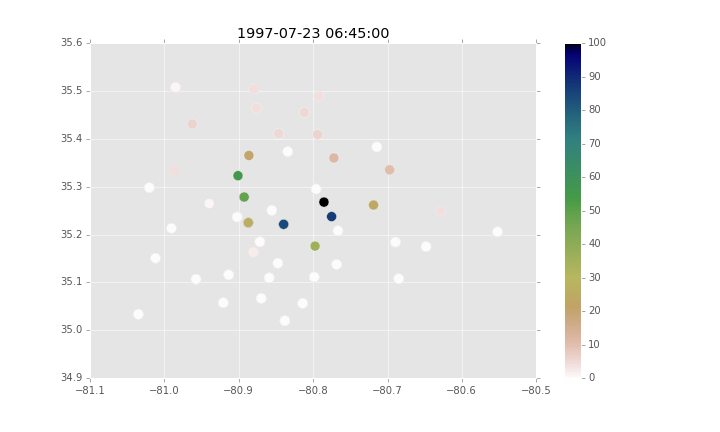
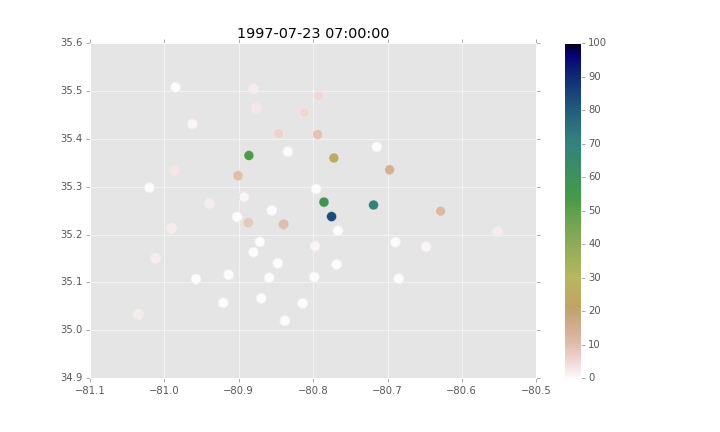
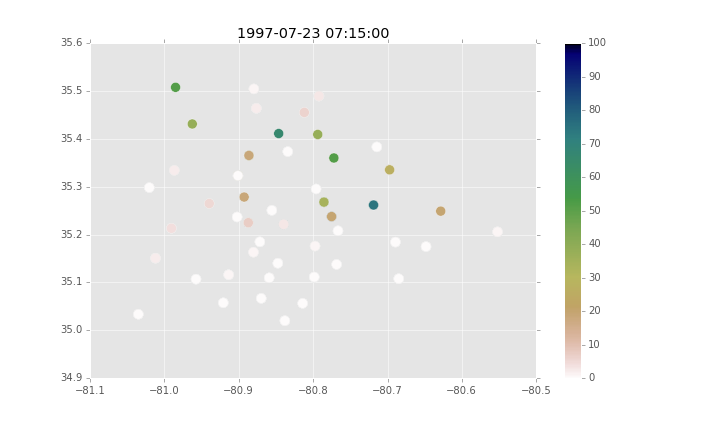
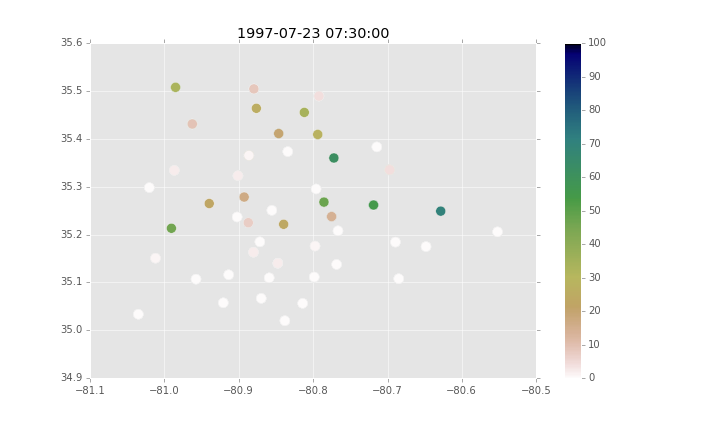
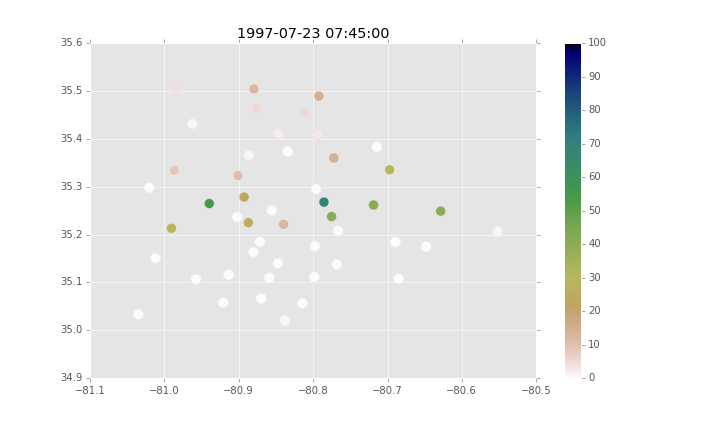
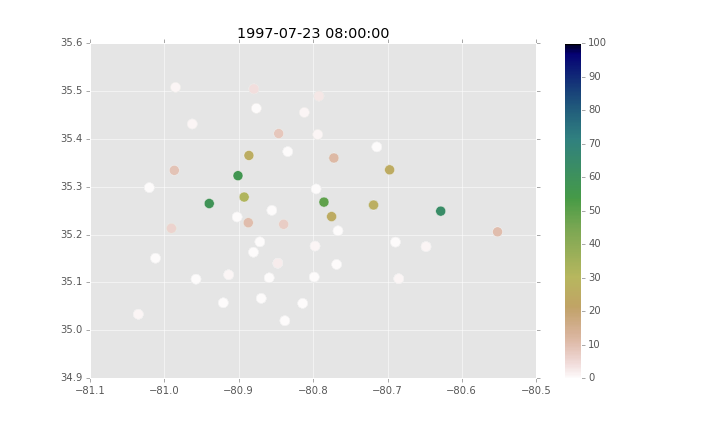
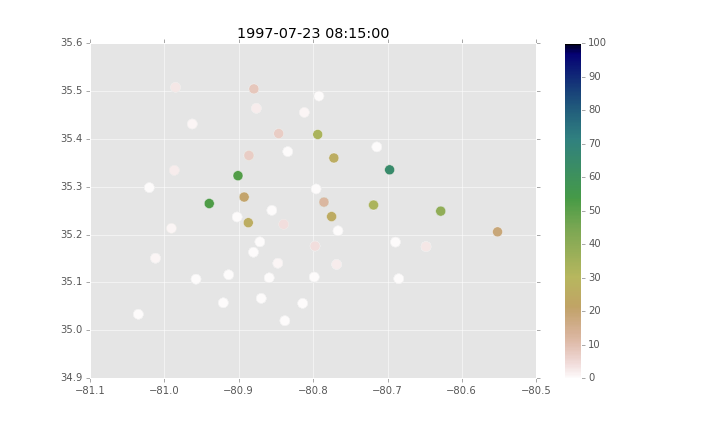
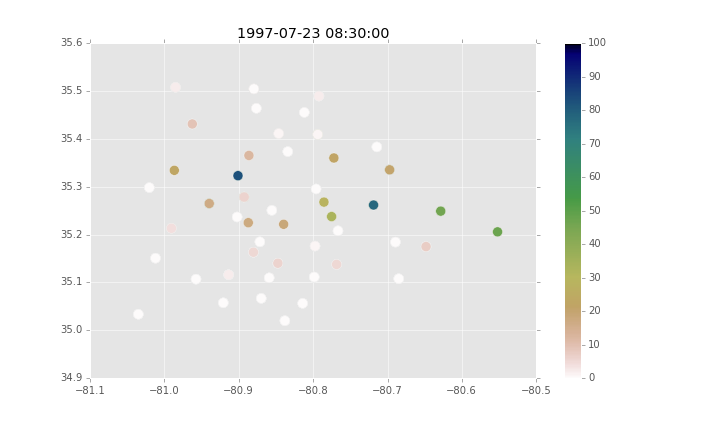
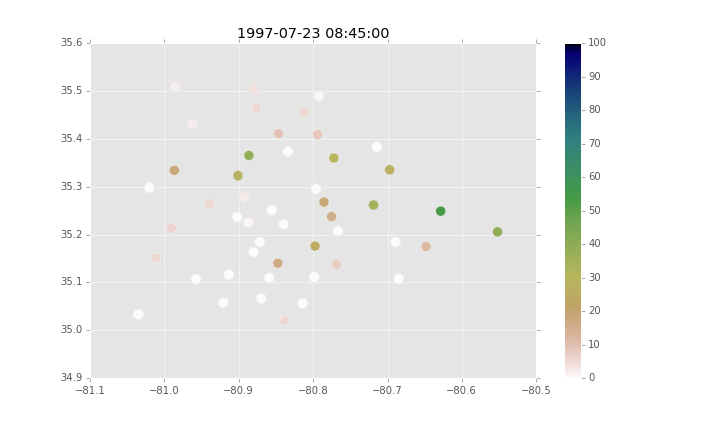
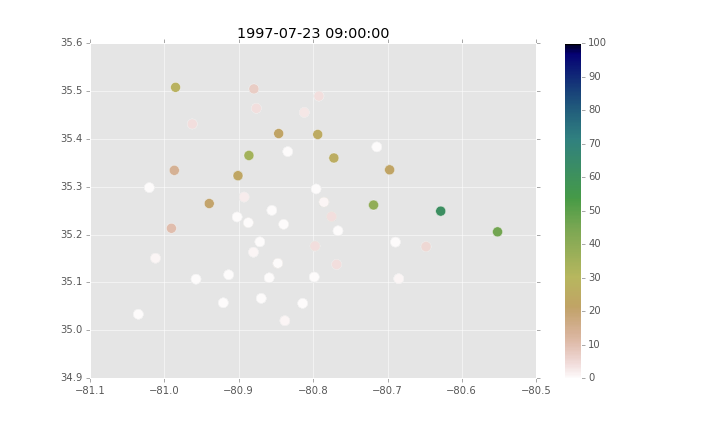
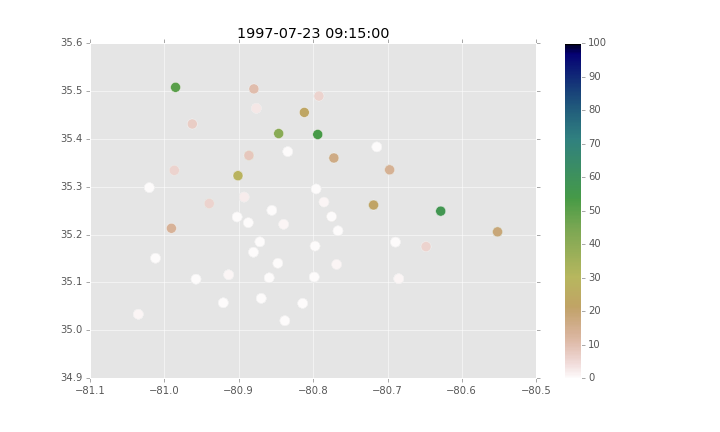
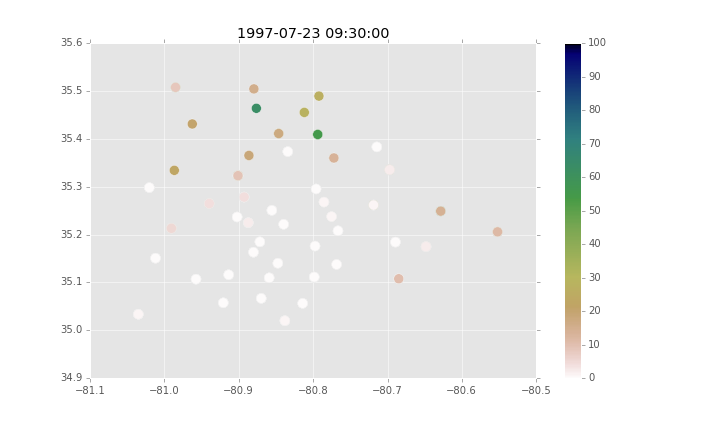
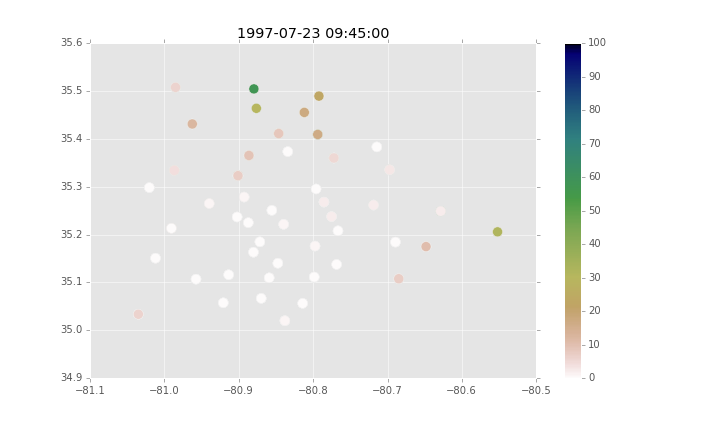
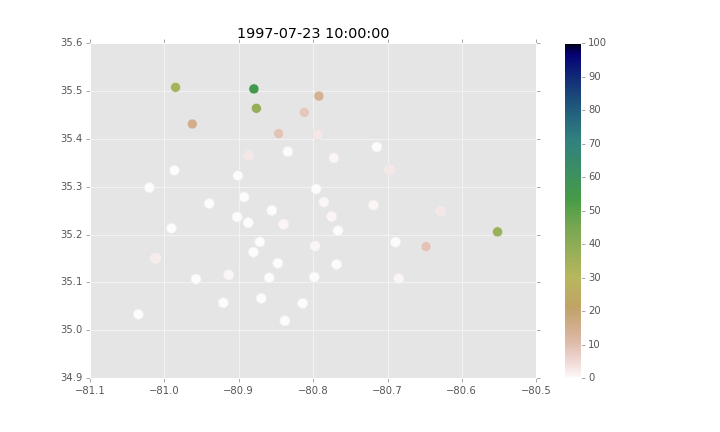
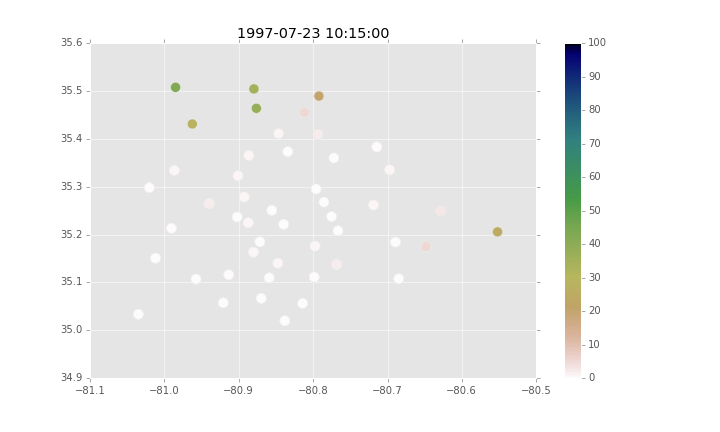
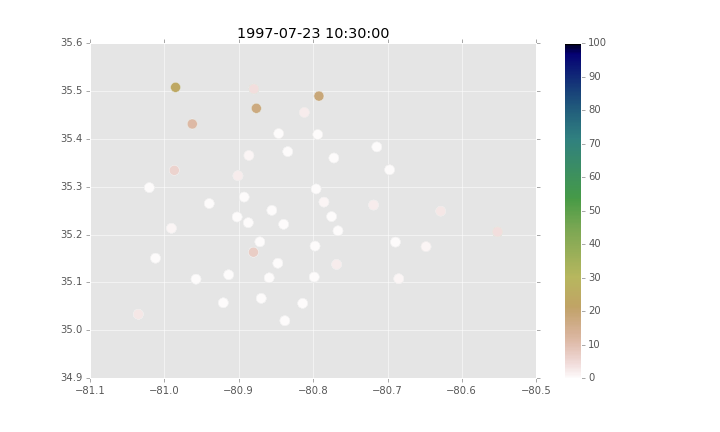
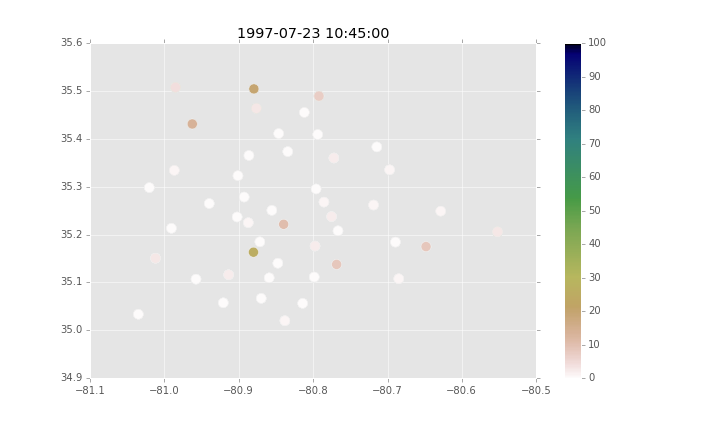
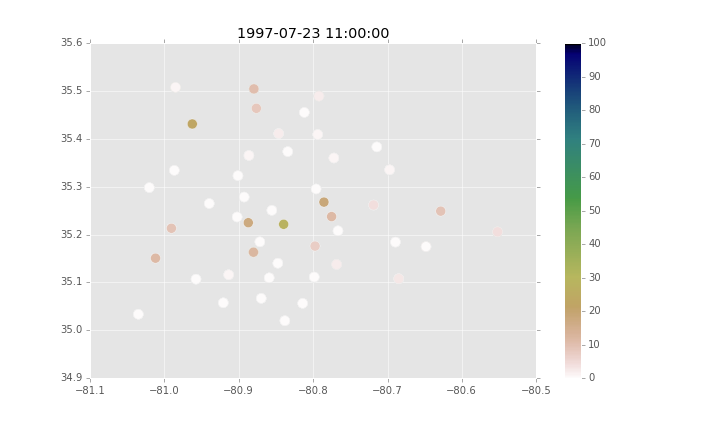
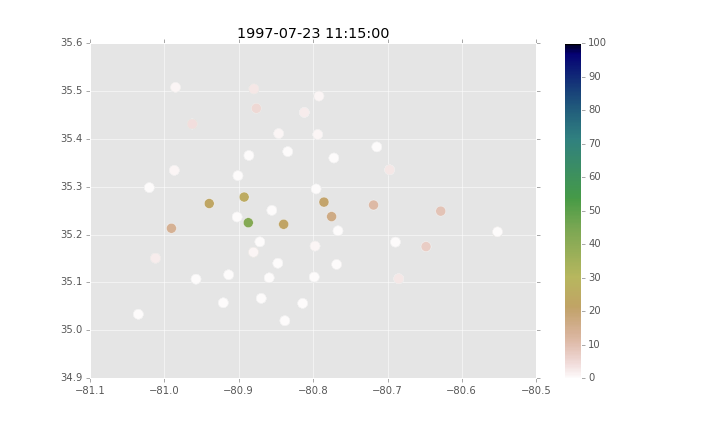
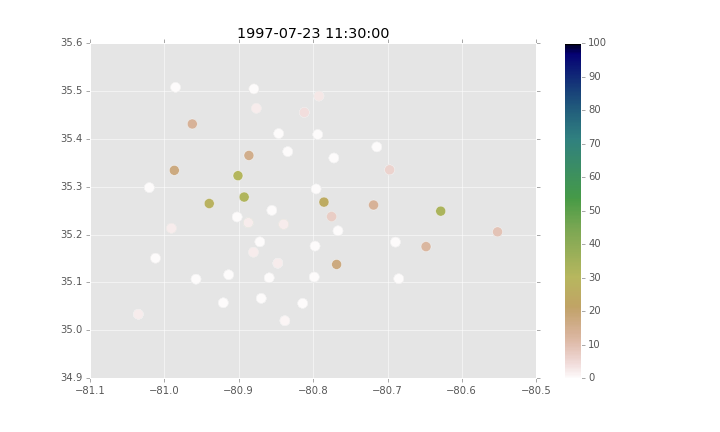
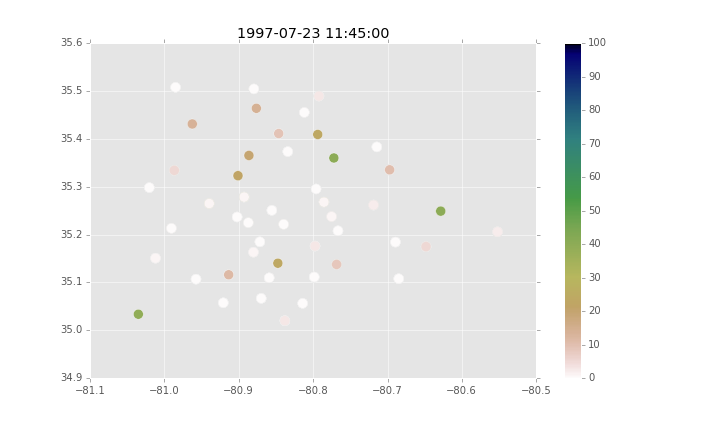
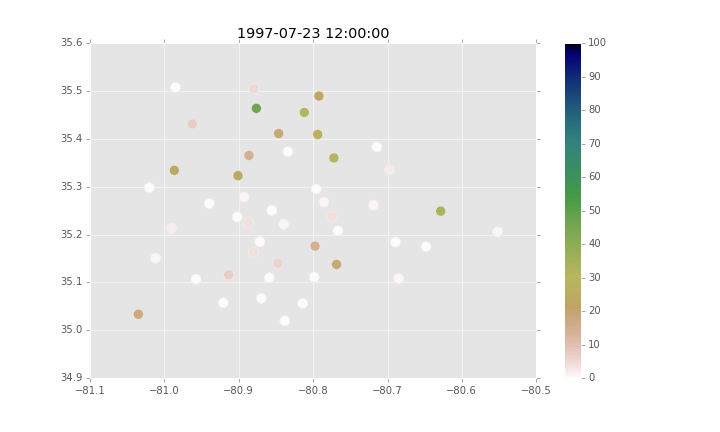
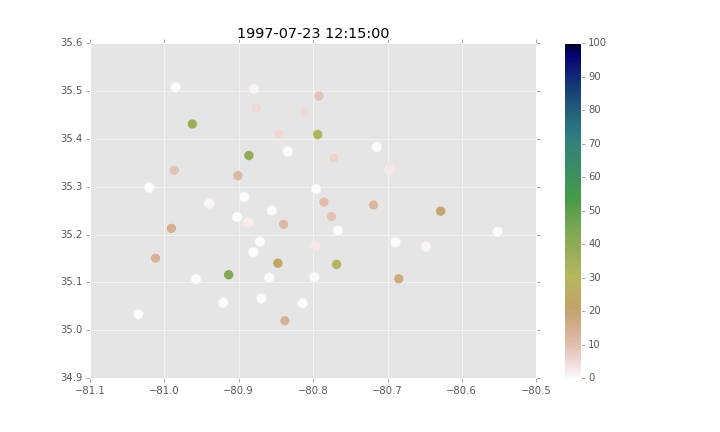
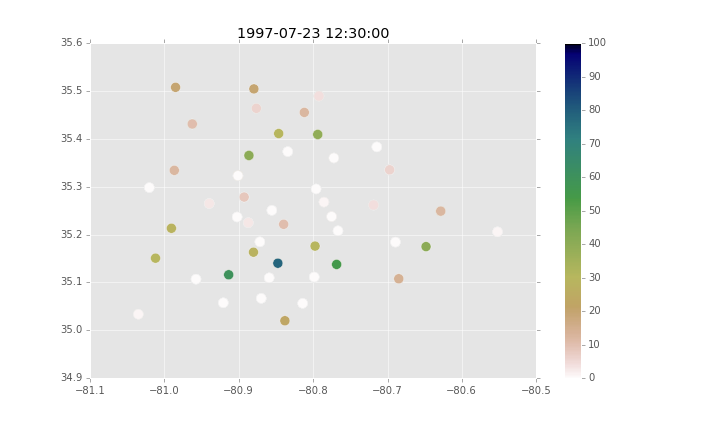
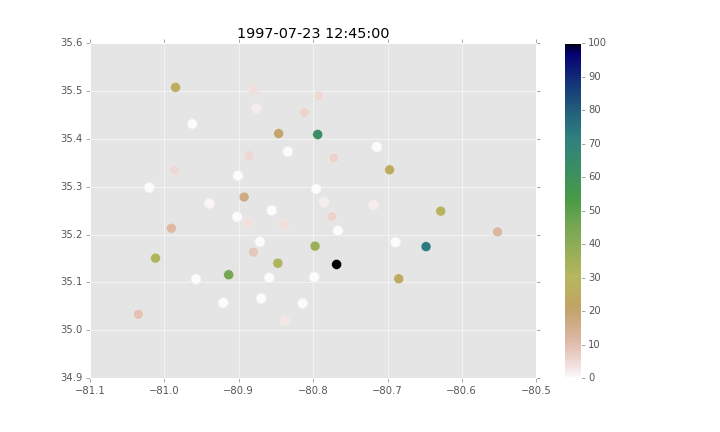
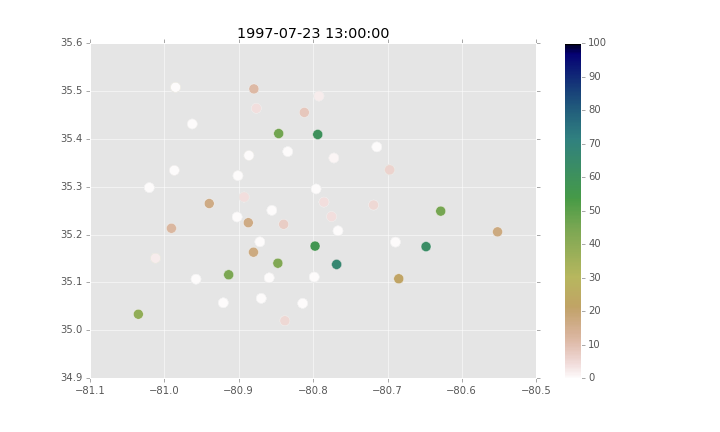
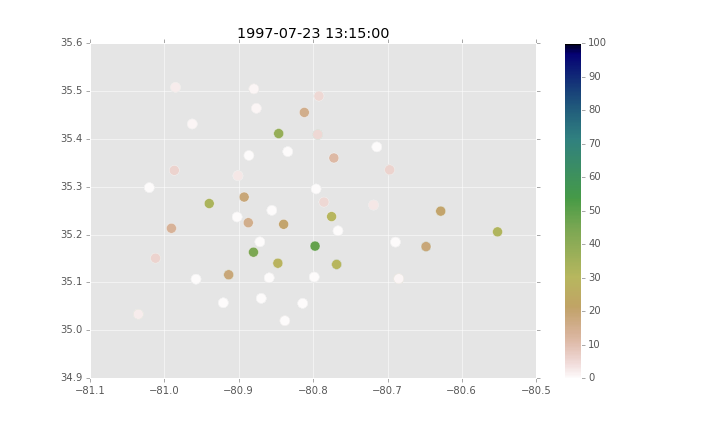
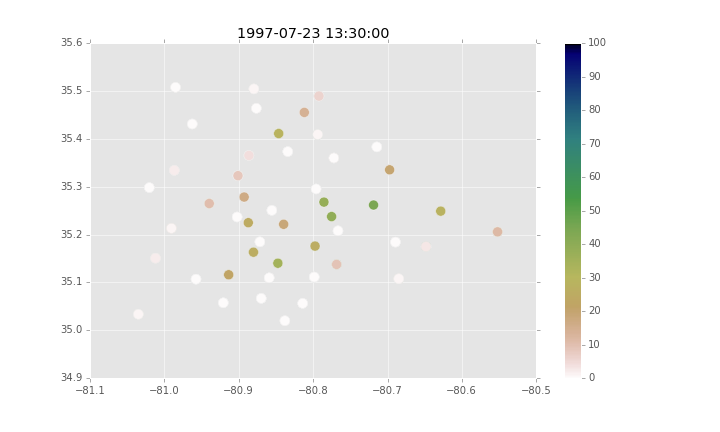
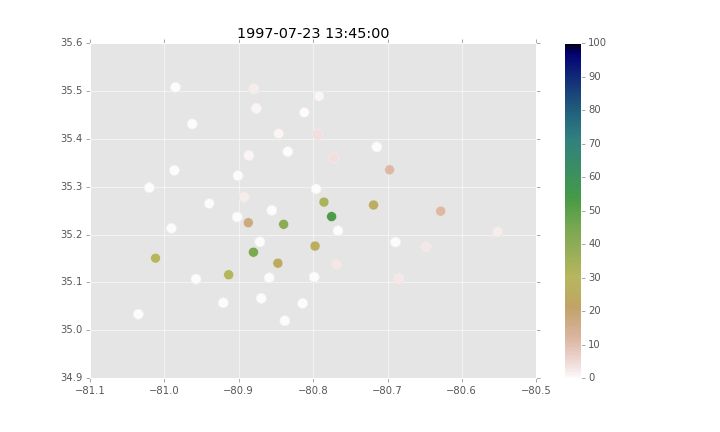
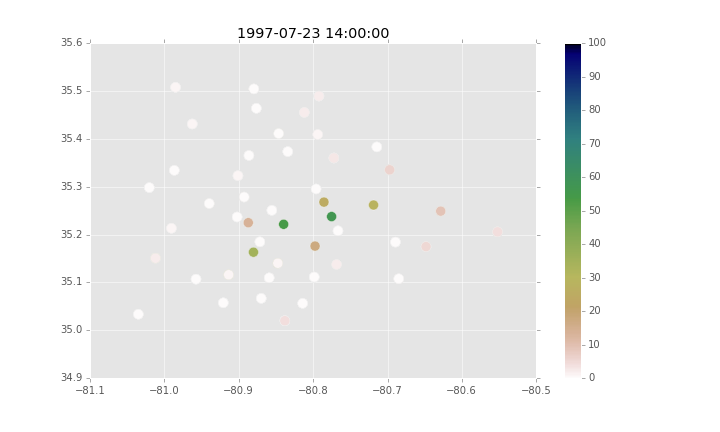
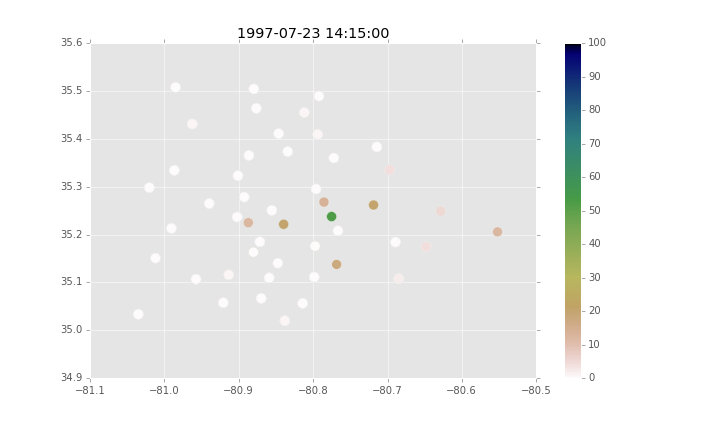
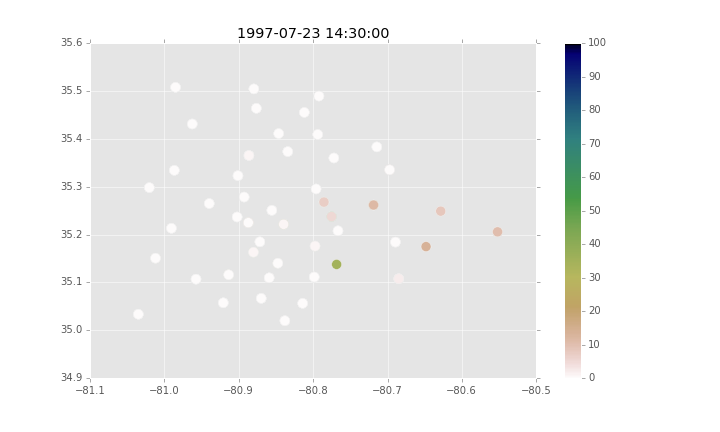
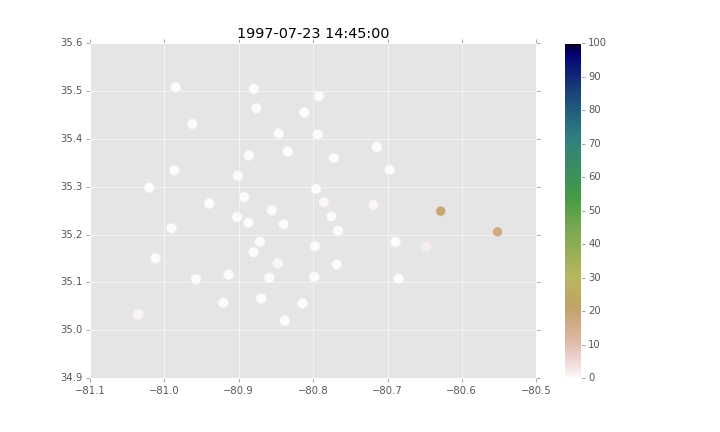
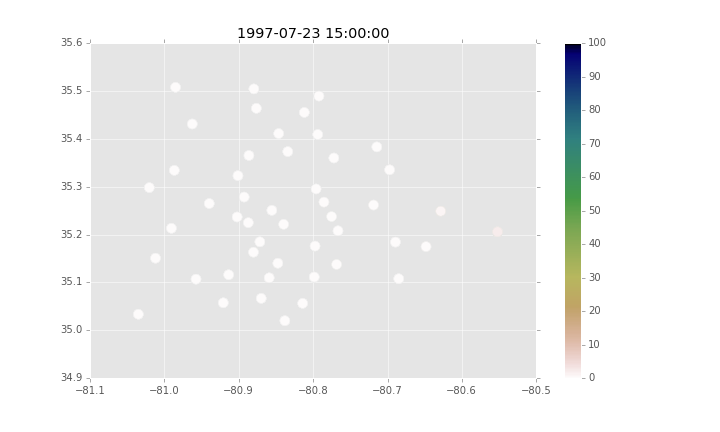
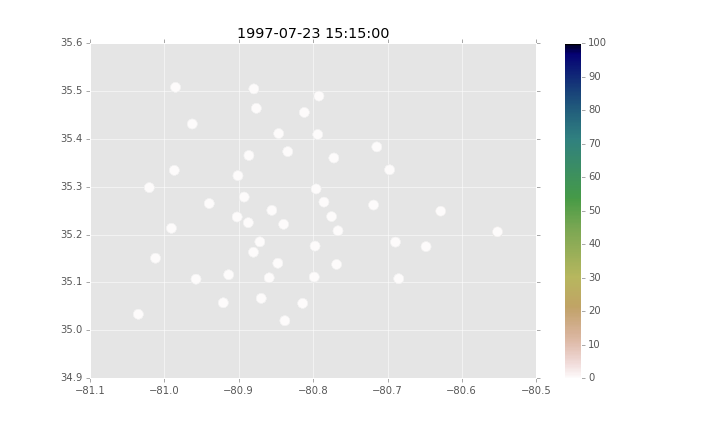
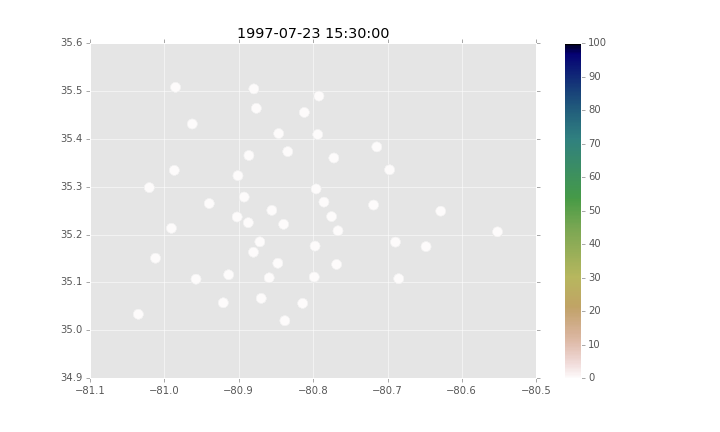
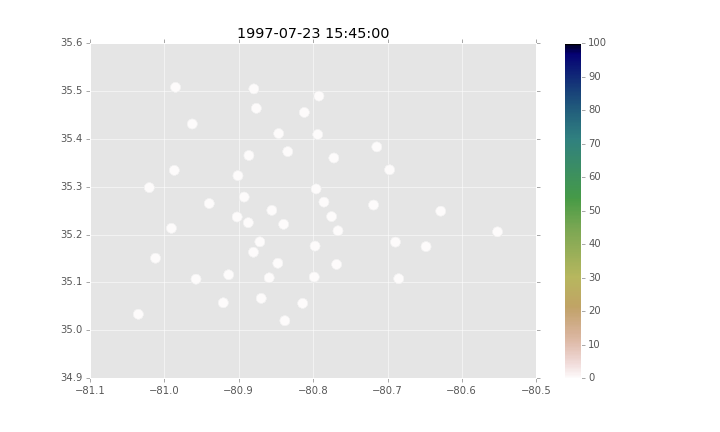
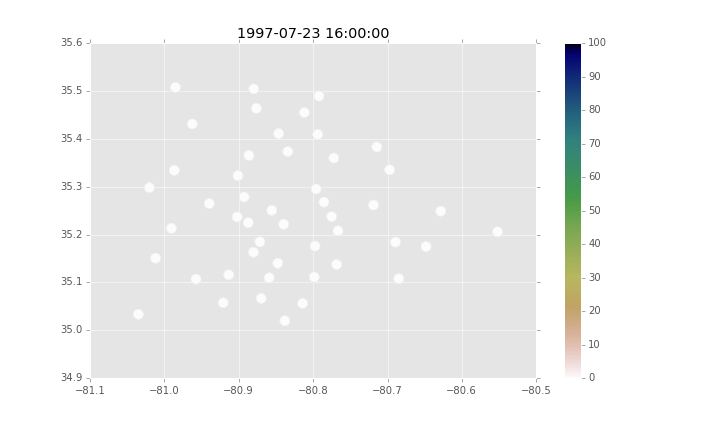
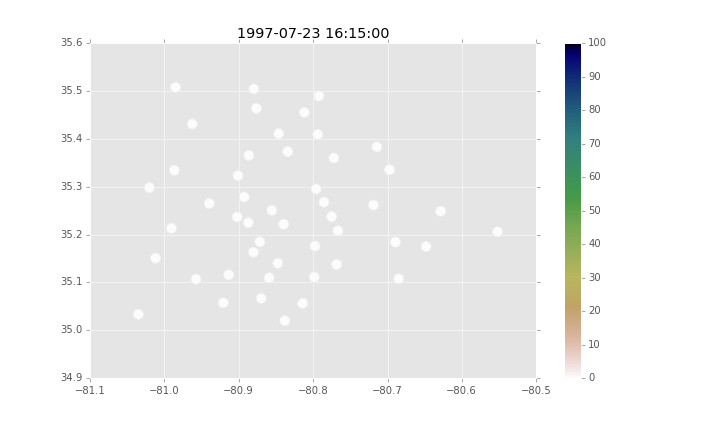
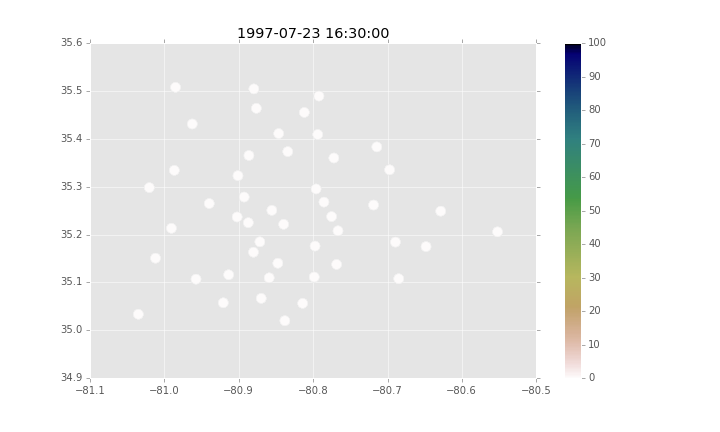
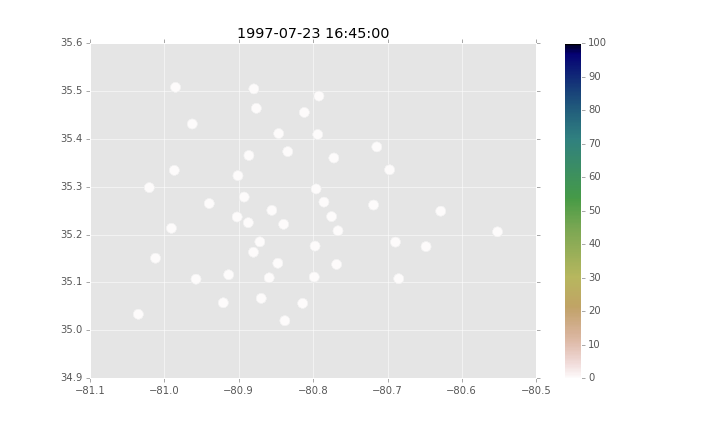
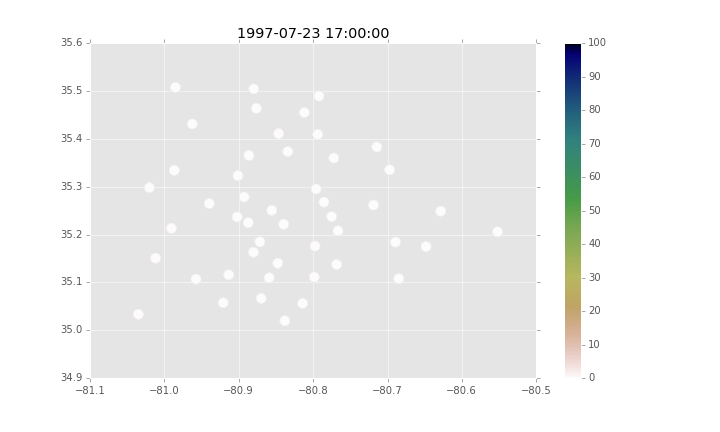
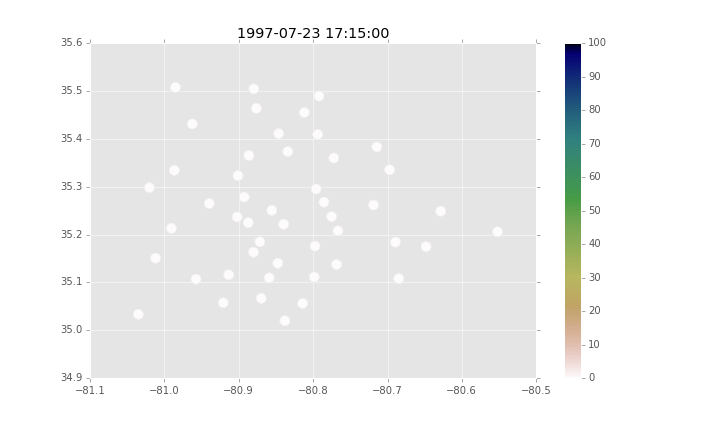
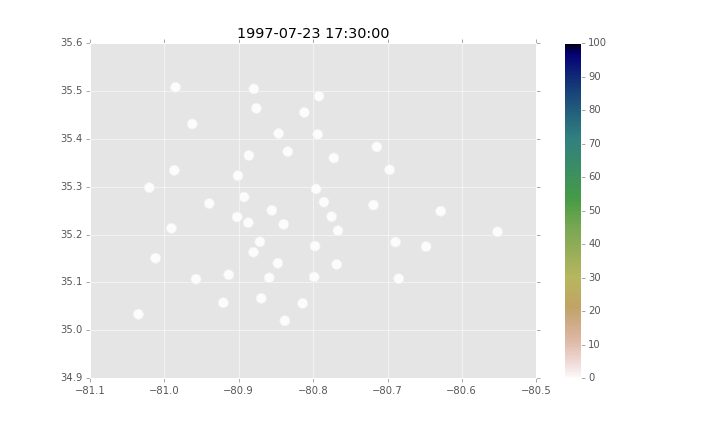
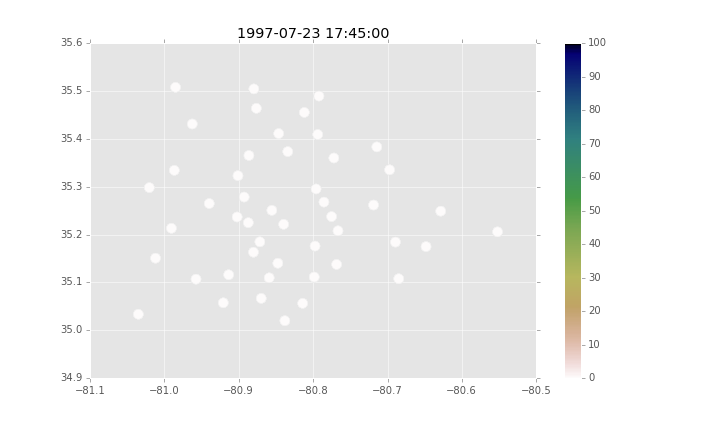
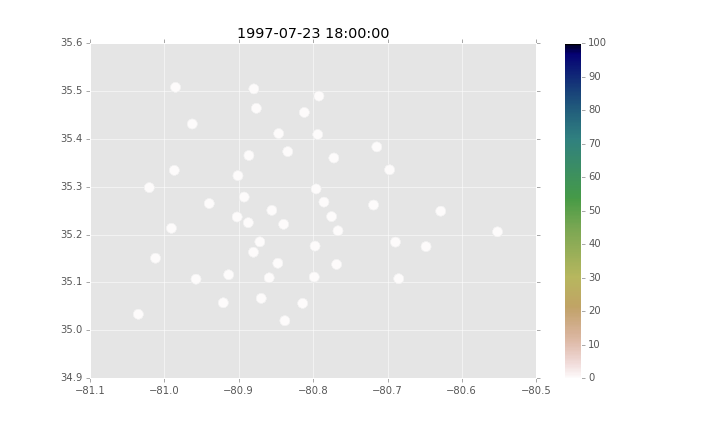
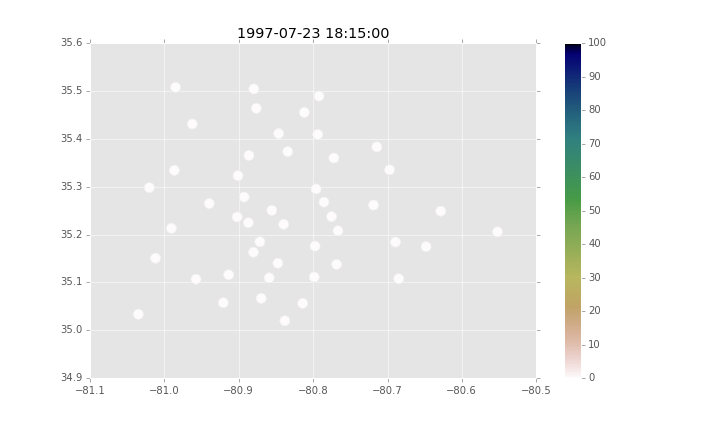
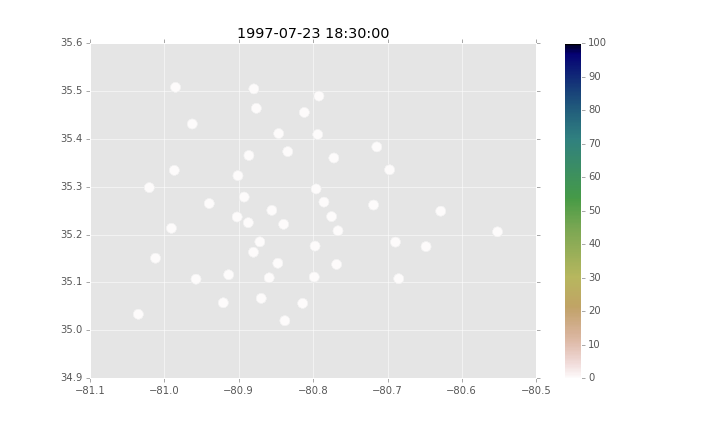
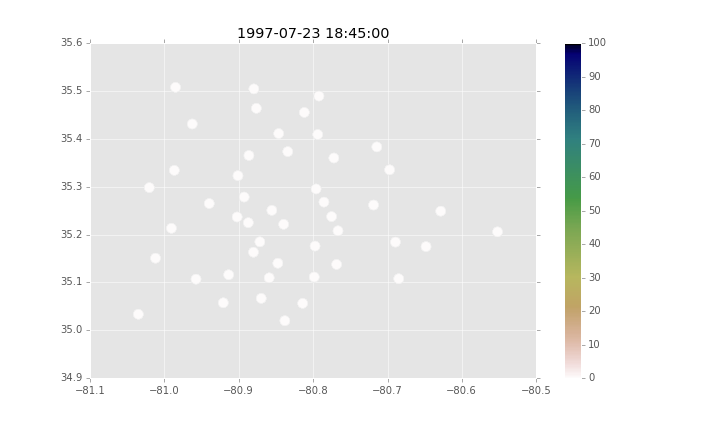
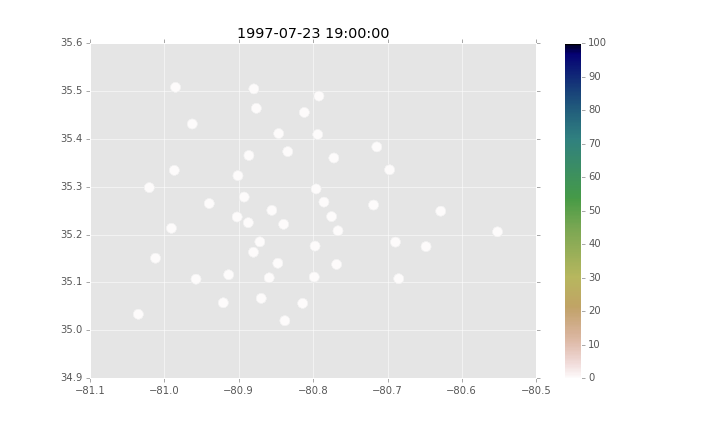
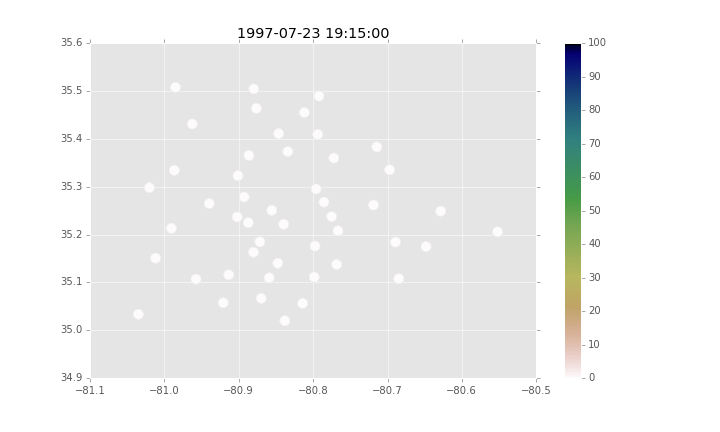
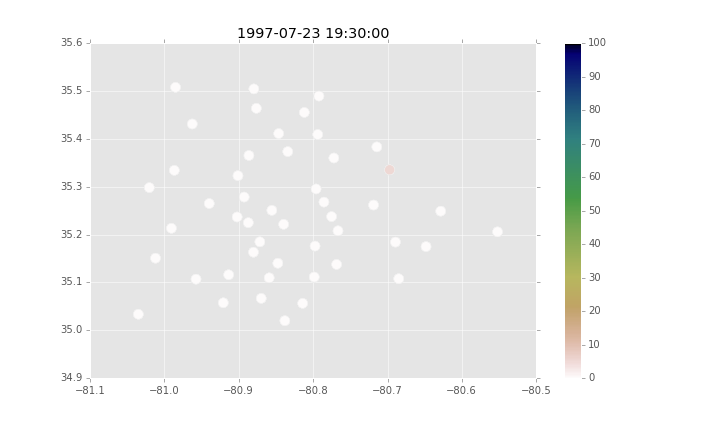
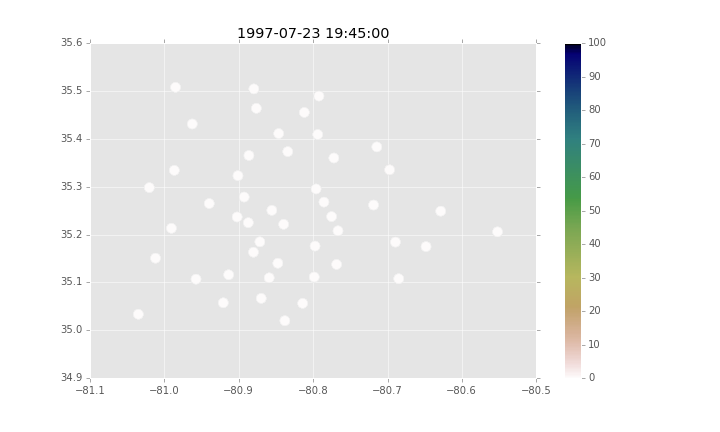
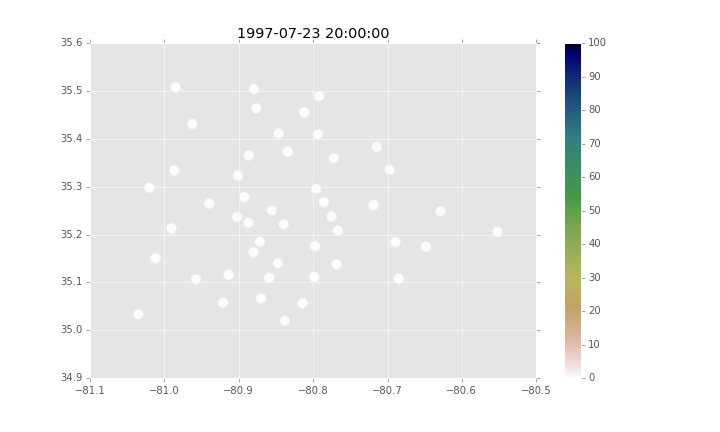
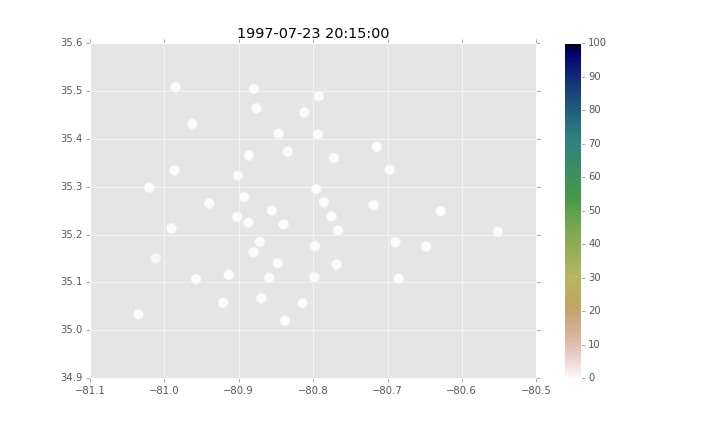
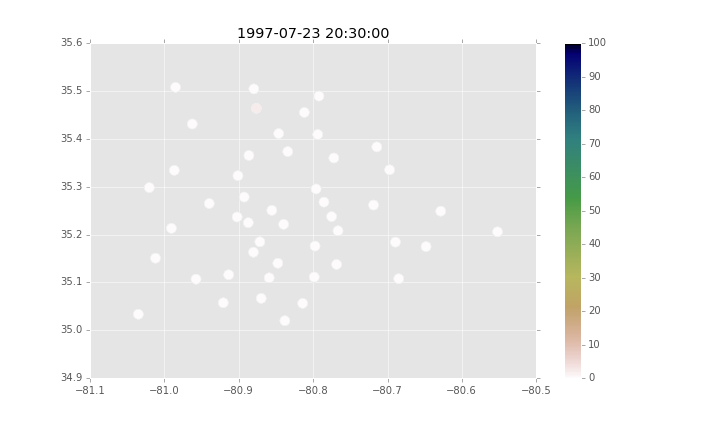
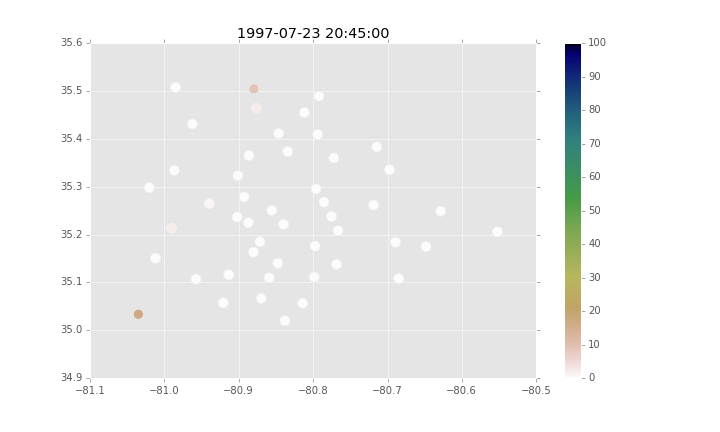
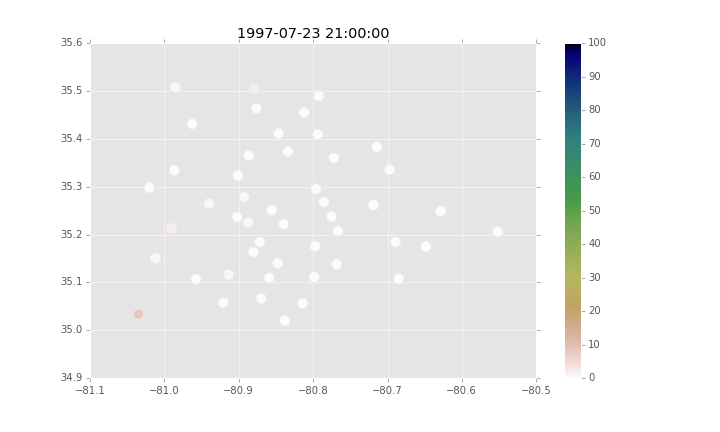
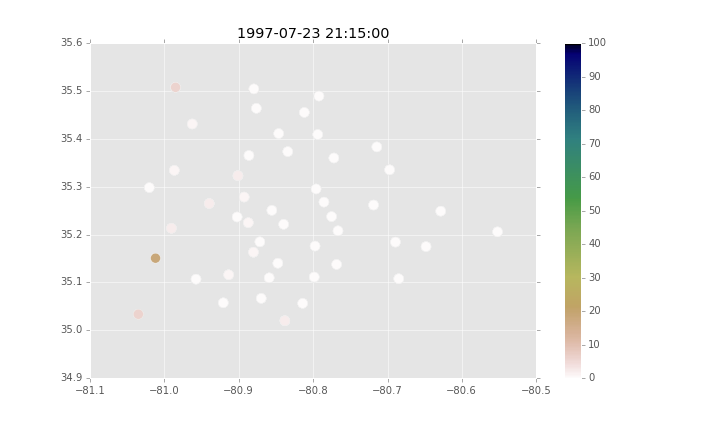
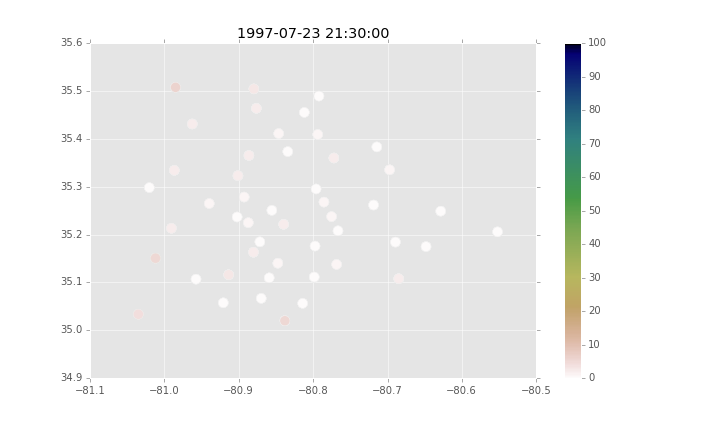
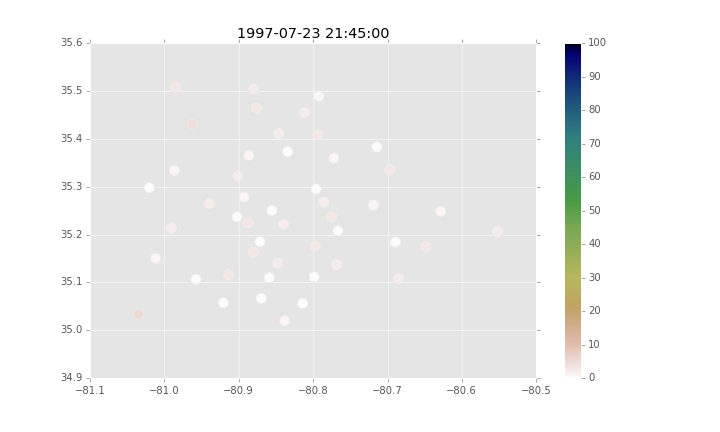
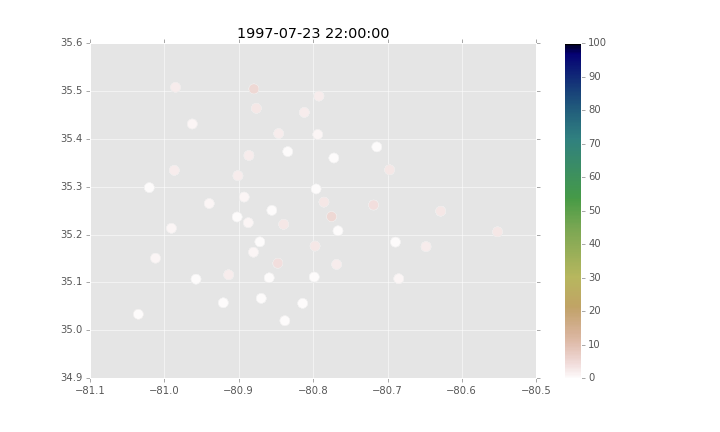
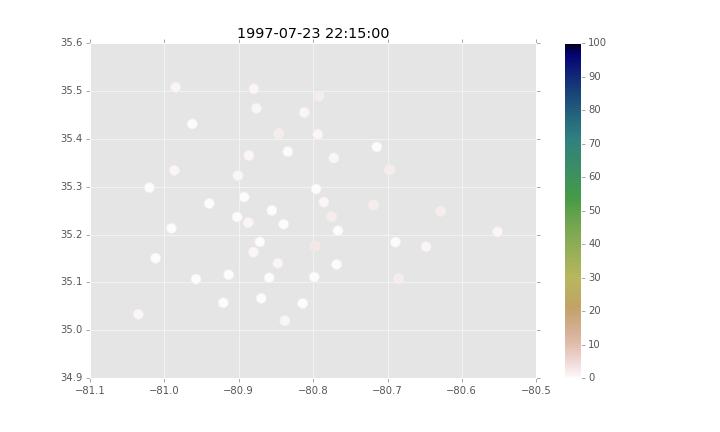
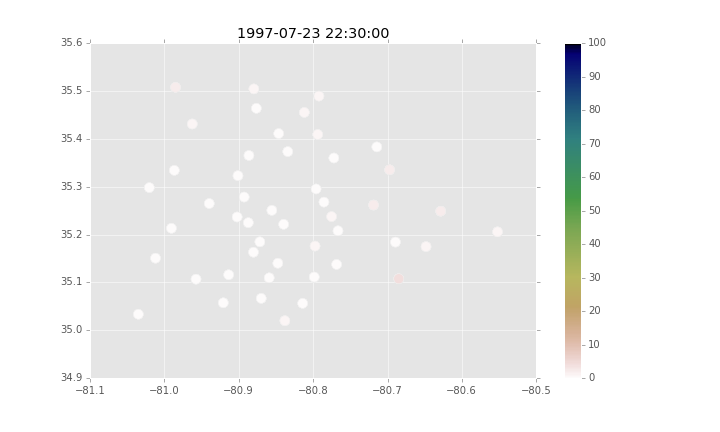
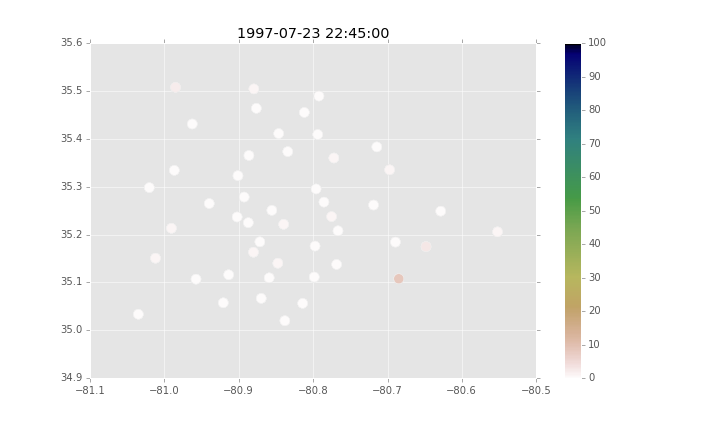
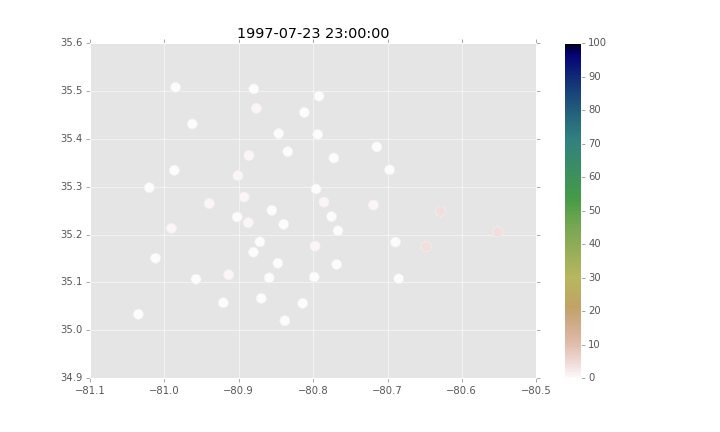
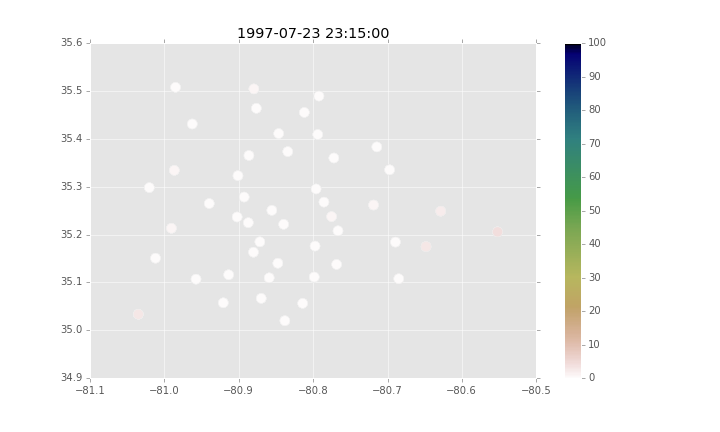
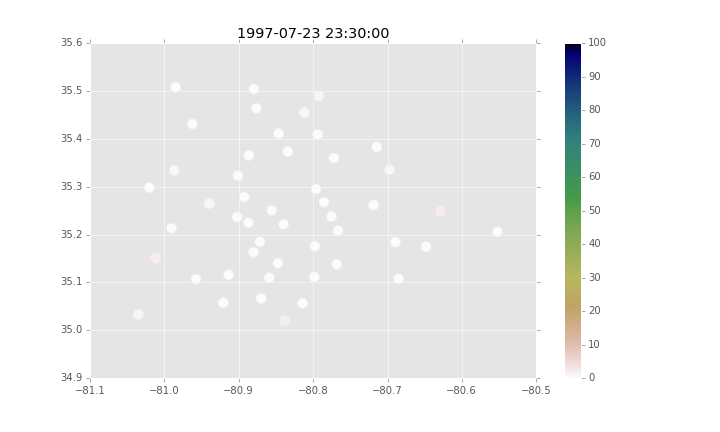
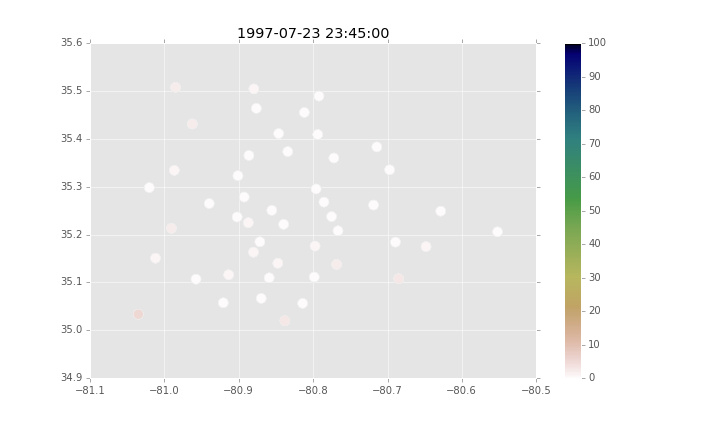

In [7]:
storm.movie()

[using ordinary kriging]
[using ordinary kriging]


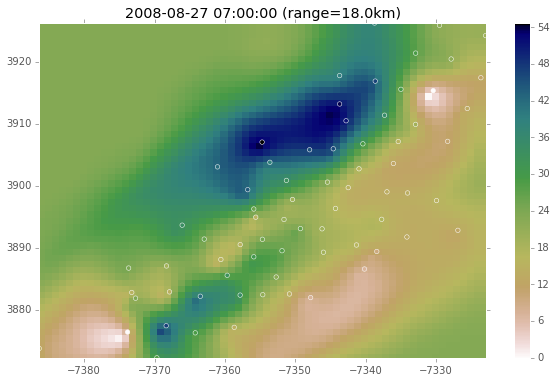

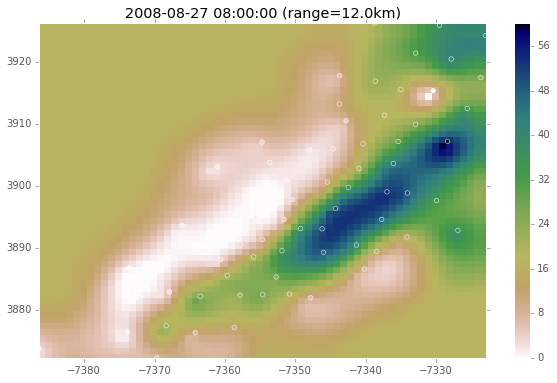

In [31]:
i = storm.df.columns.get_loc(pd.Timestamp('2008-08-27 07:00:00'))
k = storm.krige(i=i, res=False)
i = storm.df.columns.get_loc(pd.Timestamp('2008-08-27 08:00:00'))
k = storm.krige(i=i, res=False)